# Fastcampus 판매 분석

## 프로젝트 설명

- 강의를 환불하지 않은 **`고객(순구매자)`** 데이터를 타겟 변수로 지정
- VIP의 **기준**을 정한 뒤, 이들의 특성을 파악
- **시각화**를 이용하여 비교분석하면서 결론을 도출할 예정

**진행 계획**

* **결측치 전처리**
* **타겟 변수 선정**(`순 구매 테이블`)
* 타겟 변수를 가지고 **EDA** 진행<br>ex) 카테고리별 구매율, 시간별 구매율, 전체 구매율의 쿠폰 구매율 비율

**목표**

* **`순 구매 테이블`에서 충성 고객의 기준 선정**
* 기준에서 충성 고객과 일반 고객의 **수익 비율 분석**
* 분석 결과를 가지고 **결론 도출**

**일정**

- **`1차 아이데이션`**(**5/13**) : 주제 및 진행 방향 등 공유
- **`2차 아이데이션`**(**5/20**) : 진행 상황 공유
- **`최종 발표`**(**5/23**)는 당일에 랜덤 5개의 팀을 뽑아 발표.<br>**(각 팀의 발표 여부는 미리 알 수 없으니 모든 팀이 발표 준비까지 마쳐야 함!)**

## 초기 설정

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [2]:
# %matplotlib inline
# 주피터 노트북에 최적화 된 그래프 설정(코랩 사용불가)

# %matplotlib notebook
# 인터렉티브 그래프 가능(코랩 사용불가)
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
# %config InlineBackend.figure_format = 'retina'

**주피터 노트북 matplotlib 한글 설정**

In [124]:
import os

# Mac OS의 경우와 그 외 OS의 경우로 나누어 설정
if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")

**코랩 matplotlib 한글 설정**

In [5]:
# 네이버 나눔 폰트 설치
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# 실행 후 런타입 재실행

In [6]:
# 런타임 재실행 후 적용
plt.rc('font', family='NanumBarunGothic') 

**엑셀 불러오기 설정**

In [7]:
# !pip install openpyxl

테이블 시트 위치 설정

In [8]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## 변수 설명

---

-Columns

---

|Columns|Content|
|:---|:---|
|id|해당 거래내역에 대한 ID(PK)|
|customer_id|결제한 고객 ID|
|course_id|강의 ID (프로모션에 대해서는 값이 할당X)|
|type|거래의 종류|
|state|거래에 대한 상태|
|course_title|강의 제목|
|category_title|대분류|
|format|온라인 강의의 기획 종류|
|completed_at|state가 COMPLETED로 변경된 시점|
|transaction_amount|최종 결제 금액|
|coupon_title|쿠폰 종류|
|coupon_discount_amount|쿠폰 할인 금액|
|sale_price|판매 금액|
|tax_free_amount|보안상 공유가 힘듬|
|pg|PG사 종류|
|method|결제 방식|
|subcategory_title|중분류|
|marketing_start_at|강의 판매 시점|

---

-Type 유형

---

|type|유형|
|:---|:---|
|<span style="color: red">ORDER</span>|<span style="color: red">DEPRECATED</span>|
|PAYMENT|결제|
|<span style="color: red">TRANSACTION</span>|<span style="color: red">B2B계약결제(무시해도 좋음)</span>|
|REFUND|환불|

---

-State 유형

---

|state|상태|
|:---|:---|
|COMPLETED|결제 완료|
|REQUESTED|고객에게 결제 요청|
|<span style="color: red">PENDING</span>|<span style="color: red">보안 이슈로 공개X</span>|
|<span style="color: red">CANCELLED</span>|<span style="color: red">보안 이슈로 공개X</span>|
|<span style="color: red">HIDDEN</span>|<span style="color: red">보안 이슈로 공개X</span>|
|<span style="color: red">DELETE</span>|<span style="color: red">보안 이슈로 공개X</span>|

# 데이터 분석

## 데이터 전처리

In [9]:
# 데이터 불러오기
# for colab

# from google.colab import drive
# drive.mount('/content/drive')

In [10]:
train = pd.read_excel("yeardream.xlsx")

In [11]:
df = train.copy()

In [12]:
df.head()

id  customer_id  course_id     type      state  \
0  970634     504760.0   201435.0    ORDER  CANCELLED   
1  970650     432862.0   203178.0    ORDER  CANCELLED   
2  970657      72297.0   204246.0  PAYMENT  COMPLETED   
3  970656      72297.0   204246.0    ORDER  CANCELLED   
4  970658     478028.0   201797.0  PAYMENT  COMPLETED   

                    course_title category_title  format        completed_at  \
0      올인원 패키지 : 알고리즘 기술면접 완전 정복          프로그래밍     올인원 2021-03-28 15:00:11   
1    초격차 패키지 : 한번에 끝내는 영상 촬영과 편집          영상/3D     올인원 2021-03-28 15:16:53   
2           시크릿코드 : 프론트엔드 실무 완성편          프로그래밍  스쿨 온라인 2021-03-28 15:21:43   
3           시크릿코드 : 프론트엔드 실무 완성편          프로그래밍  스쿨 온라인 2021-03-28 15:21:43   
4  올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX         업무 생산성     올인원 2021-03-28 15:21:54   

   transaction_amount              coupon_title  coupon_discount_amount  \
0               90500                       NaN                     NaN   
1               96000                       NaN                     NaN   
2              171810     [10% 할인] 시크릿코드 실무 완성편                 19090.0   
3              171810                       NaN                     NaN   
4               97500  [웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰                 20000.0   

   sale_price  tax_free_amount   pg method subcategory_title  \
0    110500.0         110500.0  NaN  VBANK           개발자 커리어   
1    116000.0         116000.0  NaN   CARD             영상 편집   
2    190900.0         190900.0  NaN   CARD               NaN   
3    190900.0         190900.0  NaN   CARD               NaN   
4    117500.0         117500.0  NaN   CARD           PPT/보고서   

  marketing_start_at  
0                NaT  
1         2020-12-02  
2         2021-03-04  
3         2021-03-04  
4         2019-11-14

### 결측값 확인 및 전처리

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105419 entries, 0 to 105418
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      105419 non-null  int64         
 1   customer_id             105416 non-null  float64       
 2   course_id               100212 non-null  float64       
 3   type                    105419 non-null  object        
 4   state                   105419 non-null  object        
 5   course_title            105403 non-null  object        
 6   category_title          105395 non-null  object        
 7   format                  105403 non-null  object        
 8   completed_at            105419 non-null  datetime64[ns]
 9   transaction_amount      105419 non-null  int64         
 10  coupon_title            31817 non-null   object        
 11  coupon_discount_amount  31817 non-null   float64       
 12  sale_price              104291

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


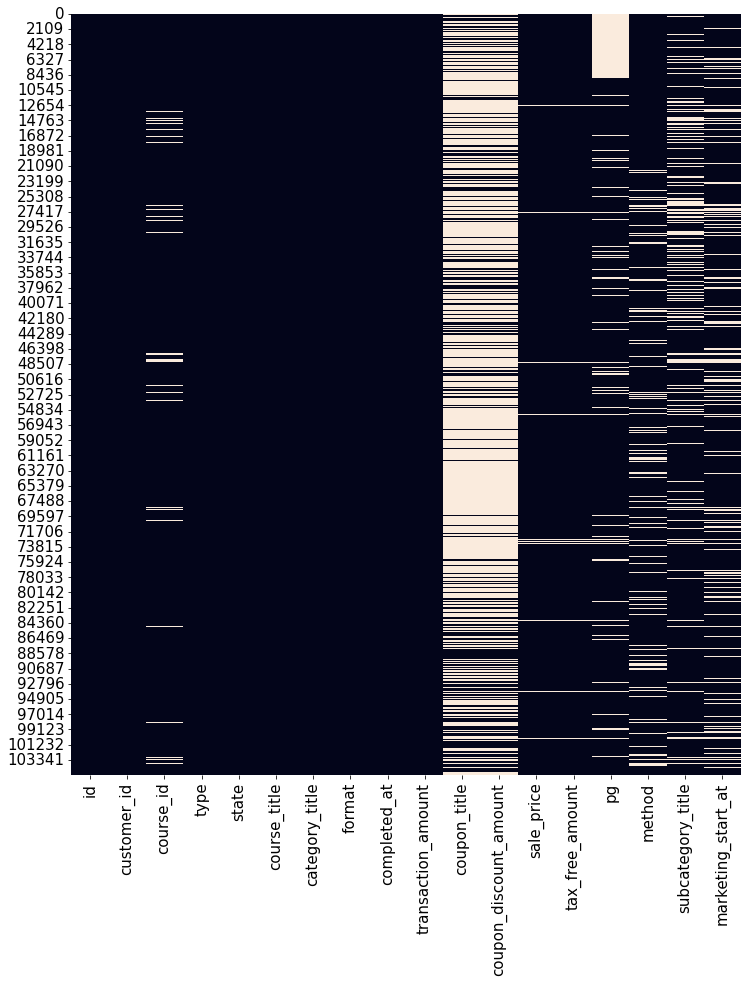

In [14]:
# 시각 자료를 이용해 결측치 확인
plt.figure(figsize=(12,14))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

확인 결과
- 컬럼별로 결측치가 많은 것을 확인할 수 있음
- 컬럼별로 결측치를 확인 진행

### customer_id

In [15]:
# 결측치 검색
df[df['customer_id'].isnull()]

id  customer_id  course_id         type      state course_title  \
12133  1011200          NaN        NaN  TRANSACTION  COMPLETED          NaN   
36367  1066932          NaN        NaN  TRANSACTION  COMPLETED          NaN   
91500  1299115          NaN        NaN  TRANSACTION  COMPLETED          NaN   

      category_title format        completed_at  transaction_amount  \
12133            NaN    NaN 2021-04-12 11:40:00                   0   
36367            NaN    NaN 2021-05-17 16:12:00                   0   
91500            NaN    NaN 2021-08-20 20:05:00                   0   

      coupon_title  coupon_discount_amount  sale_price  tax_free_amount   pg  \
12133          NaN                     NaN         NaN              NaN  NaN   
36367          NaN                     NaN         NaN              NaN  NaN   
91500          NaN                     NaN         NaN              NaN  NaN   

             method subcategory_title marketing_start_at  
12133  B2B_CONTRACT               NaN                NaT  
36367  B2B_CONTRACT               NaN                NaT  
91500  B2B_CONTRACT               NaN                NaT

- customer_id 의 결측치는 대부분 NaN이므로 삭제

In [16]:
df = df[df['customer_id'].isnull()==False] # 결측치 제거
df['customer_id'] = df['customer_id'].astype(int) # 정수형 변환

### course_id

In [17]:
df[df['course_id'].isnull()].head()

id  customer_id  course_id     type      state  \
6   970614       477910        NaN    ORDER  CANCELLED   
12  970670       429291        NaN    ORDER  CANCELLED   
13  970672       429291        NaN    ORDER  CANCELLED   
16  970677       429291        NaN    ORDER  CANCELLED   
18  970682       478031        NaN  PAYMENT  COMPLETED   

                                       course_title category_title format  \
6   프로모션 : 2021 내 커리어 지켜 줄 UX/UI 디자인 한끝세트 (3월 프리패스)         크리에이티브    올인원   
12       프로모션 : 코딩 LEVEL UP 웹 개발 풀스텍 한끝세트 (3월 프리패스)          프로그래밍    올인원   
13       프로모션 : 코딩 LEVEL UP 웹 개발 풀스텍 한끝세트 (3월 프리패스)          프로그래밍    올인원   
16       프로모션 : 코딩 LEVEL UP 웹 개발 풀스텍 한끝세트 (3월 프리패스)          프로그래밍    올인원   
18            프로모션 : 기초부터 시작하는 데이터분석 한끝세트 (3월 프리패스)        데이터사이언스    올인원   

          completed_at  transaction_amount coupon_title  \
6  2021-03-28 15:22:36              299000          NaN   
12 2021-03-28 15:27:29              299000          NaN   
13 2021-03-28 15:30:05              299000          NaN   
16 2021-03-28 15:31:29              299000          NaN   
18 2021-03-28 15:33:28              299000          NaN   

    coupon_discount_amount  sale_price  tax_free_amount   pg method  \
6                      NaN    299000.0         299000.0  NaN   CARD   
12                     NaN    299000.0         299000.0  NaN   CARD   
13                     NaN    299000.0         299000.0  NaN   CARD   
16                     NaN    299000.0         299000.0  NaN   CARD   
18                     NaN    299000.0         299000.0  NaN   CARD   

   subcategory_title marketing_start_at  
6                NaN                NaT  
12               NaN                NaT  
13               NaN                NaT  
16               NaN                NaT  
18               NaN                NaT

- 강의와 관련된 값 빼고 다른 값들이 정상적으로 들어있음
- 강의가 삭제되면서 데이터가 지워진 것으로 추정
- 결측치를 채우거나 삭제할 필요 X

### course_title

1. course_title 결측치 확인

In [18]:
df[df['course_title'].isnull()]

id  customer_id  course_id     type      state course_title  \
9002    996843       490139        NaN  PAYMENT    DELETED          NaN   
9003    996793       490089        NaN  PAYMENT    DELETED          NaN   
9004    996842       490138        NaN  PAYMENT    DELETED          NaN   
9005    996851       490149        NaN  PAYMENT    DELETED          NaN   
12181  1006736       291328        NaN  PAYMENT    DELETED          NaN   
13754  1012747       498414        NaN  PAYMENT    DELETED          NaN   
31192  1063323       524510        NaN  PAYMENT    DELETED          NaN   
38944  1093777       539708        NaN  PAYMENT    DELETED          NaN   
40377  1093780       539709        NaN  PAYMENT    DELETED          NaN   
40378  1093784       539709        NaN  PAYMENT    DELETED          NaN   
47361  1117129       549990        NaN  PAYMENT  COMPLETED          NaN   
53960  1141801       560947        NaN  PAYMENT    DELETED          NaN   
56316  1155478       567600        NaN  PAYMENT    DELETED          NaN   

      category_title format        completed_at  transaction_amount  \
9002             NaN    NaN 2021-04-07 15:05:06              480000   
9003             NaN    NaN 2021-04-07 15:05:06              600000   
9004             NaN    NaN 2021-04-07 15:05:06              600000   
9005             NaN    NaN 2021-04-07 15:05:06              600000   
12181            NaN    NaN 2021-04-12 13:10:10              967000   
13754            NaN    NaN 2021-04-15 20:40:35              170000   
31192            NaN    NaN 2021-05-10 18:04:33               35000   
38944            NaN    NaN 2021-05-22 10:57:39              127500   
40377            NaN    NaN 2021-05-24 09:18:48              110000   
40378            NaN    NaN 2021-05-24 09:18:48              110000   
47361            NaN    NaN 2021-06-02 16:48:37            10500000   
53960            NaN    NaN 2021-06-13 19:13:41              172000   
56316            NaN    NaN 2021-06-18 01:38:26             1200000   

      coupon_title  coupon_discount_amount  sale_price  tax_free_amount   pg  \
9002           NaN                     NaN         NaN              NaN  NaN   
9003           NaN                     NaN         NaN              NaN  NaN   
9004           NaN                     NaN         NaN              NaN  NaN   
9005           NaN                     NaN         NaN              NaN  NaN   
12181          NaN                     NaN         NaN              NaN  NaN   
13754          NaN                     NaN         NaN              NaN  NaN   
31192          NaN                     NaN         NaN              NaN  NaN   
38944          NaN                     NaN         NaN              NaN  NaN   
40377          NaN                     NaN         NaN              NaN  NaN   
40378          NaN                     NaN         NaN              NaN  NaN   
47361          NaN                     NaN         NaN              NaN  NaN   
53960          NaN                     NaN         NaN              NaN  NaN   
56316          NaN                     NaN         NaN              NaN  NaN   

         method subcategory_title marketing_start_at  
9002   TRANSFER               NaN                NaT  
9003   TRANSFER               NaN                NaT  
9004   TRANSFER               NaN                NaT  
9005   TRANSFER               NaN                NaT  
12181  TRANSFER               NaN                NaT  
13754  TRANSFER               NaN                NaT  
31192  TRANSFER               NaN                NaT  
38944  TRANSFER               NaN                NaT  
40377  TRANSFER               NaN                NaT  
40378  TRANSFER               NaN                NaT  
47361  TRANSFER               NaN                NaT  
53960  TRANSFER               NaN                NaT  
56316    ONSITE               NaN                NaT

In [19]:
# Payment-Completed 건이 있으나 문의 결과 제거해도 무관하다 하여 제거
df = df.dropna(subset=['course_title'])

2. "TEST", "테스트용" "검수용" 는 실제 구매 데이터가 아님. 처리 필요

2-1. 테스트용, TEST, 샘플 제거

In [20]:
# 해당 조건에 맞는 값 추출
t = df[df["course_title"].str.contains("TEST") | df["course_title"].str.contains("테스트용") | df['course_title'].str.contains("샘플")]
t

id  customer_id  course_id     type      state  \
20875  1034021        49600   205142.0  PAYMENT  COMPLETED   
20899  1034100       270040   205142.0  PAYMENT  COMPLETED   
20900  1034101       470930   205142.0  PAYMENT  COMPLETED   
20901  1034102        33271   205142.0  PAYMENT  COMPLETED   
20902  1034104       144798   205142.0  PAYMENT  COMPLETED   
...        ...          ...        ...      ...        ...   
51406  1129889       496508        NaN    ORDER  CANCELLED   
51435  1129971       496508        NaN  PAYMENT  COMPLETED   
51782  1131318       496508        NaN   REFUND  COMPLETED   
56001  1146954       496508        NaN    ORDER  CANCELLED   
56137  1147445       496508        NaN    ORDER  CANCELLED   

                                            course_title category_title  \
20875              스프링 아카데미아 15개 영상강의 코스(5월) - 샘플 강의 제공용          프로그래밍   
20899              스프링 아카데미아 15개 영상강의 코스(5월) - 샘플 강의 제공용          프로그래밍   
20900              스프링 아카데미아 15개 영상강의 코스(5월) - 샘플 강의 제공용          프로그래밍   
20901              스프링 아카데미아 15개 영상강의 코스(5월) - 샘플 강의 제공용          프로그래밍   
20902              스프링 아카데미아 15개 영상강의 코스(5월) - 샘플 강의 제공용          프로그래밍   
...                                                  ...            ...   
51406  (테스트용) 프로모션 : 기초부터 시작하는 데이터분석 프리패스 (5월 삼성 패키지 ...        데이터사이언스   
51435  (테스트용) 프로모션 : 기초부터 시작하는 데이터분석 프리패스 (5월 삼성 패키지 ...        데이터사이언스   
51782  (테스트용) 프로모션 : 기초부터 시작하는 데이터분석 프리패스 (5월 삼성 패키지 ...        데이터사이언스   
56001  (테스트용) 프로모션 : 기초부터 시작하는 데이터분석 프리패스 (5월 삼성 패키지 ...        데이터사이언스   
56137  (테스트용) 프로모션 : 기초부터 시작하는 데이터분석 프리패스 (5월 삼성 패키지 ...        데이터사이언스   

       format        completed_at  transaction_amount coupon_title  \
20875  스쿨 온라인 2021-04-27 19:03:10                   0          NaN   
20899  스쿨 온라인 2021-04-27 19:50:54                   0          NaN   
20900  스쿨 온라인 2021-04-27 19:50:57                   0          NaN   
20901  스쿨 온라인 2021-04-27 19:51:05                   0          NaN   
20902  스쿨 온라인 2021-04-27 19:51:24                   0          NaN   
...       ...                 ...                 ...          ...   
51406     올인원 2021-06-09 15:51:44              990000          NaN   
51435     올인원 2021-06-09 16:32:25              990000          NaN   
51782     올인원 2021-06-10 11:20:35             -990000          NaN   
56001     올인원 2021-06-17 13:50:43              990000          NaN   
56137     올인원 2021-06-17 17:20:09              990000          NaN   

       coupon_discount_amount  sale_price  tax_free_amount     pg     method  \
20875                     NaN         1.0              1.0    NaN  PROMOTION   
20899                     NaN         1.0              1.0    NaN  PROMOTION   
20900                     NaN         1.0              1.0    NaN  PROMOTION   
20901                     NaN         1.0              1.0    NaN  PROMOTION   
20902                     NaN         1.0              1.0    NaN  PROMOTION   
...                       ...         ...              ...    ...        ...   
51406                     NaN    990000.0         176000.0  NAVER        NaN   
51435                     NaN    990000.0         176000.0  NAVER       CARD   
51782                     NaN    990000.0         176000.0  NAVER       CARD   
56001                     NaN    990000.0         176000.0  NAVER        NaN   
56137                     NaN    990000.0         176000.0  NAVER        NaN   

      subcategory_title marketing_start_at  
20875               NaN                NaT  
20899               NaN                NaT  
20900               NaN                NaT  
20901               NaN                NaT  
20902               NaN                NaT  
...                 ...                ...  
51406               NaN                NaT  
51435               NaN                NaT  
51782               NaN                NaT  
56001               NaN                NaT  
56137               NaN                NaT  

[252 rows x 18 columns]

In [21]:
# 추려낸 이상치 값 전부 drop
df = df.drop(list(t.index))

2-2. 'A/B테스트', '코딩테스트' 제외한 '테스트' 항목 추가 제거
- 'A/B테스트', '코딩테스트'가 포함된 course_title의 경우, 실제 강의명 (테스트용이 아님)
- 해당 강의들을 제외하고 나머지 '테스트'가 포함된 row 제거

In [22]:
# 해당 단어가 포함된 course_id 검색
df[df["course_title"].str.contains("테스트")]["course_title"].unique()

array(['초격차 패키지 : 한 번에 끝내는 코딩테스트 369 Java편',
       '네카라쿠배 프론트엔드 취업완성 스쿨 2기_1차 테스트',
       '올인원 패키지 : A/B 테스트 탑재, 개인화 마케팅 끝장내기',
       '프로모션 : 2+2 코딩테스트 결과를 바꾸는 전공생 코딩 PASS (6월 프리패스)',
       '네카라쿠배 프론트엔드 취업완성 스쿨 2기_2차 테스트', '(B2B) 경남대학교_코딩 테스트 대비반',
       '프로모션 : 코딩테스트 결과를 바꾸는 전공생 코딩 BEST PASS (7월 프리패스)',
       '(초격차변경)프로모션 : 코딩테스트 결과를 바꾸는 전공생 코딩 BEST PASS (7월 프리패스)',
       '프로모션 : 코딩테스트 결과를 바꾸는 전공생 코딩 iPad 패키지 (7월 현물 프리패스)',
       'The RED : 고객 경험을 개선하는 A/B테스트 기반 모바일 앱 개발 by 이승민'], dtype=object)

In [23]:
# 해당 강의의 transaction_amount 0원, sale_price는 1원이라 이상치라 판단, drop
df[df["course_title"].str.contains("네카라쿠배 프론트엔드 취업완성 스쿨")]

id  customer_id  course_id     type      state  \
30770  1062130       523886   205237.0  PAYMENT  COMPLETED   
30783  1062160        84972   205237.0  PAYMENT  COMPLETED   
30814  1062222       513608   205237.0  PAYMENT  COMPLETED   
30822  1062238       438870   205237.0  PAYMENT  COMPLETED   
30824  1062248       523942   205237.0  PAYMENT  COMPLETED   
...        ...          ...        ...      ...        ...   
54402  1141156       546174   205715.0  PAYMENT  COMPLETED   
54447  1141335        67113   205715.0  PAYMENT  COMPLETED   
54491  1141485       523266   205715.0  PAYMENT  COMPLETED   
54611  1141900       560997   205237.0  PAYMENT  COMPLETED   
54755  1142513       524458   205237.0  PAYMENT  COMPLETED   

                        course_title category_title format  \
30770  네카라쿠배 프론트엔드 취업완성 스쿨 2기_1차 테스트          프로그래밍     스쿨   
30783  네카라쿠배 프론트엔드 취업완성 스쿨 2기_1차 테스트          프로그래밍     스쿨   
30814  네카라쿠배 프론트엔드 취업완성 스쿨 2기_1차 테스트          프로그래밍     스쿨   
30822  네카라쿠배 프론트엔드 취업완성 스쿨 2기_1차 테스트          프로그래밍     스쿨   
30824  네카라쿠배 프론트엔드 취업완성 스쿨 2기_1차 테스트          프로그래밍     스쿨   
...                              ...            ...    ...   
54402  네카라쿠배 프론트엔드 취업완성 스쿨 2기_2차 테스트          프로그래밍     스쿨   
54447  네카라쿠배 프론트엔드 취업완성 스쿨 2기_2차 테스트          프로그래밍     스쿨   
54491  네카라쿠배 프론트엔드 취업완성 스쿨 2기_2차 테스트          프로그래밍     스쿨   
54611  네카라쿠배 프론트엔드 취업완성 스쿨 2기_1차 테스트          프로그래밍     스쿨   
54755  네카라쿠배 프론트엔드 취업완성 스쿨 2기_1차 테스트          프로그래밍     스쿨   

             completed_at  transaction_amount coupon_title  \
30770 2021-05-10 10:58:57                   0          NaN   
30783 2021-05-10 11:11:21                   0          NaN   
30814 2021-05-10 11:39:56                   0          NaN   
30822 2021-05-10 11:50:03                   0          NaN   
30824 2021-05-10 11:55:30                   0          NaN   
...                   ...                 ...          ...   
54402 2021-06-14 12:34:02                   0          NaN   
54447 2021-06-14 14:25:11                   0          NaN   
54491 2021-06-14 15:46:16                   0          NaN   
54611 2021-06-14 19:25:34                   0          NaN   
54755 2021-06-15 00:11:03                   0          NaN   

       coupon_discount_amount  sale_price  tax_free_amount   pg     method  \
30770                     NaN         1.0              1.0  NaN  PROMOTION   
30783                     NaN         1.0              1.0  NaN  PROMOTION   
30814                     NaN         1.0              1.0  NaN  PROMOTION   
30822                     NaN         1.0              1.0  NaN  PROMOTION   
30824                     NaN         1.0              1.0  NaN  PROMOTION   
...                       ...         ...              ...  ...        ...   
54402                     NaN         1.0              1.0  NaN  PROMOTION   
54447                     NaN         1.0              1.0  NaN  PROMOTION   
54491                     NaN         1.0              1.0  NaN  PROMOTION   
54611                     NaN         1.0              1.0  NaN  PROMOTION   
54755                     NaN         1.0              1.0  NaN  PROMOTION   

      subcategory_title marketing_start_at  
30770               NaN         2019-04-19  
30783               NaN         2019-04-19  
30814               NaN         2019-04-19  
30822               NaN         2019-04-19  
30824               NaN         2019-04-19  
...                 ...                ...  
54402               NaN         2021-02-08  
54447               NaN         2021-02-08  
54491               NaN         2021-02-08  
54611               NaN         2019-04-19  
54755               NaN         2019-04-19  

[947 rows x 18 columns]

In [24]:
# 해당 강의들을 제외한 '테스트' 포함된 row 추려내기
t = df[~(df["course_title"].str.contains("A/B테스트"))&~(df["course_title"].str.contains("A/B 테스트"))&~(df["course_title"].str.contains("코딩 테스트"))&~(df["course_title"].str.contains("코딩테스트"))&df["course_title"].str.contains("테스트")]

In [25]:
# 추려낸 이상치 drop
df = df.drop(list(t.index))

### category_title

- category_title의 경우, null 값이 존재하나 값을 유추할 수 있는 row들이 존재
- 해당 값들은 따로 전처리
- 이 값들을 제외하고 drop

In [26]:
df[df['category_title'].isnull()]

id  customer_id  course_id     type      state  \
41878   1078156        62566        NaN   REFUND  COMPLETED   
72639   1212937       591404        NaN  PAYMENT  COMPLETED   
74973   1223470       598011        NaN    ORDER  CANCELLED   
74975   1223480       598011        NaN  PAYMENT  COMPLETED   
74980   1223479       598011        NaN    ORDER  COMPLETED   
104056  1356347       561379        NaN  PAYMENT  CANCELLED   
104318  1358067       617692        NaN  PAYMENT  CANCELLED   
105189  1363817        83845        NaN  PAYMENT  CANCELLED   

                                             course_title category_title  \
41878                                   프로모션 : 자유이용권 (3월)            NaN   
72639   프로모션 : 풀스택 데이터 사이언티스트를 위한 필수 iPad 패키지 (7월 현물 프...            NaN   
74973   프로모션 : 풀스택 데이터 사이언티스트를 위한 필수 iPad 패키지 (7월 현물 프...            NaN   
74975   프로모션 : 풀스택 데이터 사이언티스트를 위한 필수 iPad 패키지 (7월 현물 프...            NaN   
74980   프로모션 : 풀스택 데이터 사이언티스트를 위한 필수 iPad 패키지 (7월 현물 프...            NaN   
104056                  프로모션 : 영상편집 맥북 pro 패스(9월 현물 프리패스)            NaN   
104318                  프로모션 : 영상편집 맥북 pro 패스(9월 현물 프리패스)            NaN   
105189                  프로모션 : 영상편집 맥북 pro 패스(9월 현물 프리패스)            NaN   

       format        completed_at  transaction_amount coupon_title  \
41878     온라인 2021-05-26 22:06:00             -199000          NaN   
72639     올인원 2021-07-12 23:38:42              990000          NaN   
74973     올인원 2021-07-18 12:26:46              990000          NaN   
74975     올인원 2021-07-18 12:31:01              990000          NaN   
74980     올인원 2021-07-18 12:40:08              990000          NaN   
104056    올인원 2021-09-20 18:15:02             1800000          NaN   
104318    올인원 2021-09-22 00:57:03             1800000          NaN   
105189    올인원 2021-09-24 15:36:27             1800000          NaN   

        coupon_discount_amount  sale_price  tax_free_amount      pg    method  \
41878                      NaN    199000.0         199000.0     NaN  TRANSFER   
72639                      NaN    990000.0         272800.0  INICIS      CARD   
74973                      NaN    990000.0         272800.0  INICIS      CARD   
74975                      NaN    990000.0         272800.0  INICIS      CARD   
74980                      NaN    990000.0         272800.0  INICIS      CARD   
104056                     NaN   1800000.0         295200.0  INICIS      CARD   
104318                     NaN   1800000.0         295200.0   NAVER       NaN   
105189                     NaN   1800000.0         295200.0  INICIS      CARD   

       subcategory_title marketing_start_at  
41878                NaN                NaT  
72639                NaN                NaT  
74973                NaN                NaT  
74975                NaN                NaT  
74980                NaN                NaT  
104056               NaN                NaT  
104318               NaN                NaT  
105189               NaN                NaT

- customer_id = 62556 case
- course_title에 '자유이용권'이 포함되는 경우는 해당 row가 유일하며, 카테고리 분류가 애매하므로 해당 row는 drop.

- customer_id = 591404, 598011 case
- category_title 값 외에 다른 값들은 존재
- course_title에 '데이터사이언티스트' 란 단어가 포함되어 있음
- category_title을 '데이터사이언스'로 변경

In [27]:
# 인덱스(72639, 74945) 으로 접근
df.loc[72639, "category_title"] = "데이터사이언스"
df.loc[74975, "category_title"] = "데이터사이언스"

- 이 외의 값들은 유추가 어렵거나 불가능, 실제 거래도 X
- 불필요한 값이므로 drop

In [28]:
df = df.dropna(subset=["category_title"])

'데이터 사이언스' 공백 문자 제거 필요

In [29]:
def func(x):
    return x.replace(" ", "")

df['category_title'] = df['category_title'].apply(func)

In [30]:
df['category_title'].value_counts() # .nunique()

프로그래밍      33238
데이터사이언스    14082
업무생산성      13323
디자인        12009
영상/3D      10260
마케팅         9857
부동산/금융      5523
투자/재테크      2501
크리에이티브      2250
교육          1031
지식콘텐츠         56
비즈니스          42
파이낸스          25
일러스트           1
Name: category_title, dtype: int64

### subcategory_title

In [31]:
df[df['subcategory_title'].isnull()].head()

id  customer_id  course_id     type      state  \
2   970657        72297   204246.0  PAYMENT  COMPLETED   
3   970656        72297   204246.0    ORDER  CANCELLED   
6   970614       477910        NaN    ORDER  CANCELLED   
10  970671       469860   203644.0  PAYMENT  COMPLETED   
11  970668       469860   203644.0    ORDER  CANCELLED   

                                       course_title category_title  format  \
2                              시크릿코드 : 프론트엔드 실무 완성편          프로그래밍  스쿨 온라인   
3                              시크릿코드 : 프론트엔드 실무 완성편          프로그래밍  스쿨 온라인   
6   프로모션 : 2021 내 커리어 지켜 줄 UX/UI 디자인 한끝세트 (3월 프리패스)         크리에이티브     올인원   
10   올인원 패키지 : 권오상의 금융 아카데미 - 권오상의 재무제표 분석 기초(평생소장)         부동산/금융     올인원   
11   올인원 패키지 : 권오상의 금융 아카데미 - 권오상의 재무제표 분석 기초(평생소장)         부동산/금융     올인원   

          completed_at  transaction_amount           coupon_title  \
2  2021-03-28 15:21:43              171810  [10% 할인] 시크릿코드 실무 완성편   
3  2021-03-28 15:21:43              171810                    NaN   
6  2021-03-28 15:22:36              299000                    NaN   
10 2021-03-28 15:27:17              263000                    NaN   
11 2021-03-28 15:27:17              263000                    NaN   

    coupon_discount_amount  sale_price  tax_free_amount   pg method  \
2                  19090.0    190900.0         190900.0  NaN   CARD   
3                      NaN    190900.0         190900.0  NaN   CARD   
6                      NaN    299000.0         299000.0  NaN   CARD   
10                     NaN    263000.0         263000.0  NaN   CARD   
11                     NaN    263000.0         263000.0  NaN   CARD   

   subcategory_title marketing_start_at  
2                NaN         2021-03-04  
3                NaN         2021-03-04  
6                NaN                NaT  
10               NaN         2020-11-27  
11               NaN         2020-11-27

- 서브카테고리가 null일 경우, 상위 카테고리로 대체 가능
- 결측치 상위 카테고리로 대체

In [32]:
df.loc[df['subcategory_title'].isnull(),"subcategory_title"] = df.loc[df['subcategory_title'].isnull(),"category_title"]

### PAYMENT, REFUND (타겟 변수)

In [33]:
df['purchased'] = (df['type'] == 'PAYMENT') & (df['state'] == 'COMPLETED')

- payment-completed인 값 purchased column에 추가 (bool)

In [34]:
pt = df[(df['type']=='PAYMENT')&(df['state']=='COMPLETED')] # 구매 데이터
rt = df[(df['type']=='REFUND')&(df['state']=='COMPLETED')] # 환불 데이터

- 환불 데이터는 구매 데이터에 포함됨

In [35]:
paid = list(zip(pt['customer_id'].astype(float), pt['course_id'].astype(float)))
ref = list(zip(rt['customer_id'].astype(float), rt['course_id'].astype(float), rt['id']))

- 전처리를 위한 필요 컬럼데이터 추출

In [36]:
# 중요!
# [customer_id],[course_id]가 일치하는 값 = 환불 후 재구매하지 않은 케이스
# 이 외의 다른 케이스는 쿠폰 등을 사용하여 재결제 했을 가능성 있음 -> 순수 환불이 아님
# 'payment-completed'와 'refund-completed'의 [customer_id],[course_id] 비교
# 결과 값을 real_ref에 담아둔다 

real_ref = []
for i in range(len(paid)):
  for j in range(len(ref)):
    if paid[i][0] == ref[j][0] and paid[i][1] == ref[j][1]:
      real_ref.append(ref[j])
      ref.remove(ref[j])
      break

In [37]:
print(len(paid),len(real_ref),len(ref))

51707 1927 1893


- 총 결제 수 / 순수 환불 건수 / order-refund pair, 재구매, 기업강의환불 등 기타 이유

payment-completed 의 refund-completed (순수 환불) 환불데이터만  따로 분리

In [38]:
# real_refund (순수 환불 건수) Data 확인
t = np.array(real_ref)
rt = rt[rt['id'].isin(t[:,2])]
rt

id  customer_id  course_id    type      state  \
759      972662       271507   204246.0  REFUND  COMPLETED   
1165     973680       498409   203782.0  REFUND  COMPLETED   
1170     973686       462160   203328.0  REFUND  COMPLETED   
1198     973764       474332   203720.0  REFUND  COMPLETED   
1367     974226       475655   204037.0  REFUND  COMPLETED   
...         ...          ...        ...     ...        ...   
105133  1363558       656066   205761.0  REFUND  COMPLETED   
105139  1363576       648937   204013.0  REFUND  COMPLETED   
105168  1363704       670215   204670.0  REFUND  COMPLETED   
105245  1364149       604077   205569.0  REFUND  COMPLETED   
105248  1364217       552100   203525.0  REFUND  COMPLETED   

                                  course_title category_title   format  \
759                       시크릿코드 : 프론트엔드 실무 완성편          프로그래밍   스쿨 온라인   
1165                   초격차 패키지 : 한번에 끝내는 모션그래픽          영상/3D      올인원   
1170               올인원 패키지 : 디자이너 몰래 듣는 압축 포토샵            디자인      올인원   
1198               초격차 패키지 : 한 번에 끝내는 프론트엔드 개발          프로그래밍      올인원   
1367                매주)서비스 기획서 완성 온라인 완주반 2101         크리에이티브  온라인 완주반   
...                                        ...            ...      ...   
105133              초격차 패키지 : 한 번에 끝내는 디지털 마케팅            마케팅      올인원   
105139                 올인원 패키지 : 완전정복 시각디자인 기초            디자인      올인원   
105168  The RED : 김영하 작가의 내 안의 숨은 이야기를 찾아 쓰는 법            마케팅      RED   
105245           올인원 패키지 : 공여사와 무작정 풀어보는 엑셀 실무          업무생산성      올인원   
105248  초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터          프로그래밍      올인원   

              completed_at  transaction_amount coupon_title  \
759    2021-03-29 10:28:46             -171810          NaN   
1165   2021-03-29 14:39:49             -139000          NaN   
1170   2021-03-29 14:41:27              -77600          NaN   
1198   2021-03-29 14:58:53             -111000          NaN   
1367   2021-03-29 17:23:15             -367000          NaN   
...                    ...                 ...          ...   
105133 2021-09-24 13:33:08             -213000          NaN   
105139 2021-09-24 13:43:57              -72000          NaN   
105168 2021-09-24 14:32:43             -171000          NaN   
105245 2021-09-24 17:09:30             -109000          NaN   
105248 2021-09-24 17:33:53             -108186          NaN   

        coupon_discount_amount  sale_price  tax_free_amount      pg method  \
759                        NaN    190900.0         190900.0     NaN   CARD   
1165                       NaN    139000.0         139000.0     NaN   CARD   
1170                       NaN     87600.0          87600.0     NaN   CARD   
1198                       NaN    111000.0         111000.0     NaN   CARD   
1367                       NaN    417000.0         417000.0     NaN   CARD   
...                        ...         ...              ...     ...    ...   
105133                     NaN    233000.0         233000.0  INICIS   CARD   
105139                     NaN    174000.0         174000.0   NAVER   CARD   
105168                     NaN    171000.0         171000.0   NAVER  TRANS   
105245                     NaN    129000.0         129000.0   KAKAO  POINT   
105248                     NaN    114000.0         114000.0  INICIS   CARD   

       subcategory_title  marketing_start_at  purchased  
759                프로그래밍 2021-03-04 00:00:00      False  
1165               모션그래픽 2021-01-22 00:00:00      False  
1170                디자인툴 2020-10-23 00:00:00      False  
1198            프론트엔드 개발 2021-02-02 00:00:00      False  
1367              크리에이티브 2021-01-14 00:00:00      False  
...                  ...                 ...        ...  
105133            디지털마케팅 2021-08-17 00:00:00      False  
105139             시각디자인 2021-03-16 00:00:00      False  
105168         글쓰기/카피라이팅 2021-06-18 17:00:00      False  
105245            엑셀/VBA 2021-08-17 00:00:00      False  
105248            백엔드 개발 2021-02-01 00:00:00   

In [39]:
51743-1927

49816

payment-completed 테이블에서 이와 짝이 맞는 refund 값을 빼주면 49816이 나와야 한다

In [40]:
for i in range(len(df)):
  a = float(df.iloc[i,1]) # = customer_id
  b = float(df.iloc[i,2]) # = course_id
  if df.iloc[i,18] == True: # = purchased = True인 값
    for j in range(len(real_ref)): # 값 비교
      if real_ref[j][0] == a and real_ref[j][1] == b: # 환불 리스트에 해당 customer_id, course_id 있을 경우
          df.iloc[i,18] = False # True에서 False로 변경
          real_ref.remove(real_ref[j]) # 중복 방지를 위해 해당 값 삭제
          break

* purchased = True 값 중 환불이 이뤄진 경우 -> 최종적으로 구매한 값 X
* 데이터 내 purchased = True인 값 중 real_ref와 값이 겹칠 경우 False로 바꿈

In [41]:
df['purchased'].value_counts()

False    54418
True     49780
Name: purchased, dtype: int64

- 성공적으로 줄어든 모습 확인

In [42]:
# 순 구매 건 확인
pt = df[df['purchased'] == True]
pt

id  customer_id  course_id     type      state  \
2        970657        72297   204246.0  PAYMENT  COMPLETED   
4        970658       478028   201797.0  PAYMENT  COMPLETED   
8        970669       478033   203178.0  PAYMENT  COMPLETED   
10       970671       469860   203644.0  PAYMENT  COMPLETED   
18       970682       478031        NaN  PAYMENT  COMPLETED   
...         ...          ...        ...      ...        ...   
105411  1364969       669238   204286.0  PAYMENT  COMPLETED   
105412  1364976       384003   203178.0  PAYMENT  COMPLETED   
105413  1364991       670891   203935.0  PAYMENT  COMPLETED   
105416  1364996       640697   205365.0  PAYMENT  COMPLETED   
105418  1365007       610626   206720.0  PAYMENT  COMPLETED   

                                          course_title category_title  format  \
2                                 시크릿코드 : 프론트엔드 실무 완성편          프로그래밍  스쿨 온라인   
4                        올인원 패키지 : 직장인 필수 스킬 3종 세트 MAX          업무생산성     올인원   
8                          초격차 패키지 : 한번에 끝내는 영상 촬영과 편집          영상/3D     올인원   
10      올인원 패키지 : 권오상의 금융 아카데미 - 권오상의 재무제표 분석 기초(평생소장)         부동산/금융     올인원   
18               프로모션 : 기초부터 시작하는 데이터분석 한끝세트 (3월 프리패스)        데이터사이언스     올인원   
...                                                ...            ...     ...   
105411                      초격차 패키지 : 한번에 끝내는 3D 디자인 툴            디자인     올인원   
105412                     초격차 패키지 : 한번에 끝내는 영상 촬영과 편집          영상/3D     올인원   
105413                     초격차 패키지 : 한 번에 끝내는 파이썬 웹 개발          프로그래밍     올인원   
105416                 초격차 패키지 : 한 번에 끝내는 유튜브 크리에이터 되기          영상/3D     올인원   
105418                              용호수의 돈 버는 실전 영상 제작          영상/3D     올인원   

              completed_at  transaction_amount               coupon_title  \
2      2021-03-28 15:21:43              171810      [10% 할인] 시크릿코드 실무 완성편   
4      2021-03-28 15:21:54               97500   [웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰   
8      2021-03-28 15:26:47               96000   [웰컴쿠폰] 올인원 패키지 2만원 할인 쿠폰   
10     2021-03-28 15:27:17              263000                        NaN   
18     2021-03-28 15:33:28              299000                        NaN   
...                    ...                 ...                        ...   
105411 2021-09-25 13:39:26              212000    [미래투자금] 온라인 강의 2만원 할인쿠폰   
105412 2021-09-25 13:46:29              149000                        NaN   
105413 2021-09-25 14:01:26              159000    [미래투자금] 온라인 강의 2만원 할인쿠폰   
105416 2021-09-25 14:17:41               96000  [WELCOME] 온라인 강의 2만원 할인쿠폰   
105418 2021-09-25 14:25:47              139000  [WELCOME] 온라인 강의 3만원 할인쿠폰   

        coupon_discount_amount  sale_price  tax_free_amount      pg method  \
2                      19090.0    190900.0         190900.0     NaN   CARD   
4                      20000.0    117500.0         117500.0     NaN   CARD   
8                      20000.0    116000.0         116000.0     NaN   CARD   
10                         NaN    263000.0         263000.0     NaN   CARD   
18                         NaN    299000.0         299000.0     NaN   CARD   
...                        ...         ...              ...     ...    ...   
105411                 20000.0    232000.0         232000.0  INICIS   CARD   
105412                     NaN    149000.0         149000.0   KAKAO   CARD   
105413                 20000.0    179000.0         179000.0  INICIS   CARD   
105416                 20000.0    116000.0         116000.0  INICIS  VBANK   
105418                 30000.0    169000.0         169000.0   NAVER  POINT   

       subcategory_title marketing_start_at  purchased  
2                  프로그래밍         2021-03-04       True  
4                PPT/보고서         2019-11-14       True  
8                  영상 편집         2020-12-02       True  
10                부동산/금융         2020-11-27       True  
18               데이터사이언스                NaT       True  
...                  ...                ...        ...  
105411              디자

### price
- 일반적으로 강의를 결제할 경우 tax_free_amount와 sale price 가격이 동일하나, 일부 강의의 경우 서로 가격이 다른 경우가 있음
- 세전 금액과 sale_price가 다른경우(예시 : 현물프리패스 등) 실수익은 세전금액이라고 예측 가능
- 'revenue'란 컬럼 생성하여 쿠폰이 없는 경우에는 tax_free_amount, 있는 경우에는 transaction_amount 로 대체하여 실제 거래 가격을 넣어줌
- 쿠폰을 사용한 경우와 사용하지 않은 경우를 나누고, 사은품을 끼워서 판매한 강의도 나눔
- 사은품을 끼워 판 강의는 판매가격과 실제 수익이 다름

In [43]:
pt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49780 entries, 2 to 105418
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   id                      49780 non-null  int64         
 1   customer_id             49780 non-null  int32         
 2   course_id               47802 non-null  float64       
 3   type                    49780 non-null  object        
 4   state                   49780 non-null  object        
 5   course_title            49780 non-null  object        
 6   category_title          49780 non-null  object        
 7   format                  49780 non-null  object        
 8   completed_at            49780 non-null  datetime64[ns]
 9   transaction_amount      49780 non-null  int64         
 10  coupon_title            22928 non-null  object        
 11  coupon_discount_amount  22928 non-null  float64       
 12  sale_price              48715 non-null  float

In [44]:
# taxfreeamount와 saleprice 가 다른 강좌들은 모두 쿠폰이 없음
pt[(pt["sale_price"]!= pt["tax_free_amount"]) & (~pt["coupon_title"].isnull())]

id  customer_id  course_id     type      state  \
90776   1294906       636868   207018.0  PAYMENT  COMPLETED   
91173   1297293       576889   207018.0  PAYMENT  COMPLETED   
91235   1297690       551722   207018.0  PAYMENT  COMPLETED   
91340   1298260       465057   207018.0  PAYMENT  COMPLETED   
91450   1298849        43421   207018.0  PAYMENT  COMPLETED   
91648   1299763       567768   207018.0  PAYMENT  COMPLETED   
91657   1299787       145454   207018.0  PAYMENT  COMPLETED   
91773   1300260       558182   207018.0  PAYMENT  COMPLETED   
92616   1303890       559793   207018.0  PAYMENT  COMPLETED   
92914   1305377       577873   207018.0  PAYMENT  COMPLETED   
93821   1309984       565650   207018.0  PAYMENT  COMPLETED   
97387   1325302       578212   207018.0  PAYMENT  COMPLETED   
98272   1329809       153064   207018.0  PAYMENT  COMPLETED   
100876  1340025       520784   207018.0  PAYMENT  COMPLETED   

                                       course_title category_title format  \
90776   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
91173   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
91235   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
91340   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
91450   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
91648   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
91657   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
91773   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
92616   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
92914   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
93821   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
97387   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
98272   K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   
100876  K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)          프로그래밍    B2G   

              completed_at  transaction_amount  \
90776  2021-08-18 17:06:15                   0   
91173  2021-08-19 21:18:31                   0   
91235  2021-08-20 00:58:38                   0   
91340  2021-08-20 13:31:48                   0   
91450  2021-08-20 17:38:33                   0   
91648  2021-08-21 12:55:36                   0   
91657  2021-08-21 13:31:01                   0   
91773  2021-08-21 21:25:46                   0   
92616  2021-08-24 09:41:40                   0   
92914  2021-08-25 00:03:00                   0   
93821  2021-08-27 14:07:05                   0   
97387  2021-09-02 16:19:00                   0   
98272  2021-09-06 09:13:55                   0   
100876 2021-09-10 16:52:27                   0   

                                      coupon_title  coupon_discount_amount  \
90776   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
91173   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
91235   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
91340   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
91450   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
91648   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
91657   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
91773   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
92616   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
92914   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
93821   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
97387   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
98272   K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                300000.0   
100876  K-Digital Credit 빅데이터분석 첫걸음 시작하기_1기(평생소장용)                30

In [45]:
# sale_pric와 tax_free_amount가 다른 경우
pt[(pt["sale_price"]!= pt["tax_free_amount"])]["course_title"].value_counts()

데이터 사이언스 취업완성 스쿨 17기                               79
스프링 아카데미아                                          36
K-Digital Credit 빅데이터 분석 첫걸음 시작하기_1기(평생소장용)        14
프로모션 : 개발자를 위한 코딩 만능 백과사전 iPad 패키지 (7월 현물 프리패스)     8
프로모션 : 아이패드 200%활용 드로잉 만랩 iPad 패키지 (7월 현물 프리패스)     8
                                                   ..
(B2B) 노스글로벌 온라인 구독 올 플랜 - 비대면바우처                    1
(B2B) 일모작 온라인 구독 올 플랜 - 비대면바우처                      1
(B2B) (주)창소프트아이앤아이 온라인 구독 올 플랜 - 비대면바우처             1
(B2B) 주식회사 폴몬 온라인 구독 올 플랜 - 비대면바우처                  1
(B2B) (주)오디 온라인 구독 올 플랜 - 비대면바우처                    1
Name: course_title, Length: 985, dtype: int64

In [46]:
# 현물 프리패스
pt[(pt["course_title"].str.contains("현물"))]["course_title"].value_counts()

프로모션 : 아이패드 200%활용 드로잉 만랩 iPad 패키지 (7월 현물 프리패스)                   8
프로모션 : 개발자를 위한 코딩 만능 백과사전 iPad 패키지 (7월 현물 프리패스)                   8
프로모션 : 데이터 분석 맥북 pro 패스(9월 현물 프리패스)                               7
프로모션 : 나를 위한  데이터사이언스 백과사전  iPad 패키지 (7월 현물 프리패스)                 6
프로모션 : 디자인 맥북 pro 패스(9월 현물 프리패스)                                  4
프로모션 : 영상 퀄리티를 높이는  전문가 편집스킬 iPad 패키지 (7월 현물 프리패스)                4
프로모션 : 직장인 필수 스킬 맥북 pro 패스(9월 현물 프리패스)                            3
프로모션 : 초봉을 바꾸는 주니어를 위한 개발 iPad 패키지 (7월 현물 프리패스)                   3
프로모션 : 유튜버 따라잡고 실버버튼 받는 영상 iPad 패키지 (7월 현물 프리패스)                  3
프로모션 : 트렌드 완벽정복! 일잘러 마케터  iPad 패키지 (7월 현물 프리패스)                   3
프로모션 : 기초부터 다지는 데이터분석 iPad 패키지 (7월 현물 프리패스)                       3
프로모션 : 풀스택 개발자 맥북 air 패스(9월 현물 프리패스)                              3
프로모션 : 프론트엔드 맥북 pro 패스 (9월 현물 프리패스)                               3
프로모션 : 콘텐츠 디자이너를 위한 커리어 백과사전 iPad 패키지 (7월 현물 프리패스)                2
프로모션 : 풀스택 마케터를 위한 마케팅 iPad 패키지 (7월 현물 프리패스)    

In [47]:
# 타겟변수 다시 정제
pt["revenue"] = pt["coupon_title"].isnull() * pt["tax_free_amount"] + ~pt["coupon_title"].isnull() *pt["transaction_amount"]
# revenue가 null값인 경우 transaction amount 로 값 변경(쿠폰은 없지만 tax_free_amount가 null인경우.. 주로 b2b)
pt.loc[pt["revenue"].isnull(),"revenue"] = pt.loc[pt["revenue"].isnull(),"transaction_amount"]

C:\Users\leehy\AppData\Local\Temp\ipykernel_14192\1748054951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pt["revenue"] = pt["coupon_title"].isnull() * pt["tax_free_amount"] + ~pt["coupon_title"].isnull() *pt["transaction_amount"]


In [48]:
# 수익과 구매 횟수별 pivot table
t = pt.groupby("customer_id").agg({"revenue": "sum","id":'count'}).sort_values(by=["id","revenue"], ascending=False)
t

revenue  id
customer_id               
98685        7040750.0  53
427973             0.0  47
158374             0.0  42
50769        4979110.0  39
3189               0.0  39
...                ...  ..
658695             0.0   1
659634             0.0   1
659805             0.0   1
665031             0.0   1
666156             0.0   1

[37601 rows x 2 columns]

### coupon_title
- course_title과 마찬가지로, 테스트 값 존재
- 해당 값들 선별 후 drop

#### 테스트

In [49]:
t = pt[~pt["coupon_title"].isnull()]
t1 = t[t['coupon_title'].str.contains("검수용")] # 검수용
t2 = t[t['coupon_title'].str.contains("테스트") | t['coupon_title'].str.contains("TEST")] # 테스트

- coupon_title에 "검수용"이 포함된 경우 drop

In [50]:
pt = pt.drop(list(t1.index))

- coupon_title에 "테스트","TEST"가 포함된 경우


- '테스트'가 포함된 값들 중에 테스트용이 아닌 값들 존재
- 해당 값들 제외하고 drop

In [51]:
t2['coupon_title'].unique()

array(['[무료수강권] CRM팀 테스트용_김경진 개인계정 (이메일 인증 안 된 계정)', '[내부직원] 테스트용 결제 쿠폰',
       '테스트쿠폰', 'TEST이제너두_직장인을 위한 파이썬 데이터 분석', 'TEST',
       '[무료수강권] 초격차 패키지: 한 번에 끝내는 코딩테스트 369 Java편_이준희 강사님', '호준 테스트',
       '이웅모 강사님 강의 준비용 쿠폰 발급_초격차 패키지 : 한 번에 끝내는 코딩테스트 369 Java편',
       '[테스트쿠폰] 네이버 페이 간편결제 테스트용 쿠폰', '테스트_전지현', '[CX] 관리자 외 계정 테스트용',
       '테스트', '[cs팀] 테스트 결제 위한 쿠폰 발급',
       '[30%쿠폰] The RED 고객 경험을 개선하는 A/B테스트 기반 모바일 앱 개발 신규 강의 할인'],
      dtype=object)

- '30%쿠폰~', '초격차 패키지: 한 번에 끝내는 코딩테스트 369 Java편_이준희 강사님' 
- 두 케이스는 실제 강의 이므로 해당 강의들 제외하고 Drop

In [52]:
t3 = t2.loc[~t2['coupon_title'].str.startswith("[30%쿠폰]")]
t3 = t3.drop(33173) # 이준희 강사

In [53]:
pt = pt.drop(list(t3.index))

#### 내부자용 쿠폰제거
- 최종 결제 가격이 0원인 거래들 다수 발견
- 정상 거래가 아니라 판단되어 해당 조건으로 검색 결과 쿠폰명에 일반 쿠폰과 다른 이름들 발견
- 해당 거래들 조회하여 제거

In [54]:
df[df["transaction_amount"]==0]["coupon_title"].unique()

array(['한 번에 끝내는 Java/Sring 웹 개발 마스터 초격차 패키지 무료 쿠폰 (-2/28)',
       '수강생 50만명 돌파 기념 감사제 쿠폰', '[웰컴쿠폰] 올인원 패키지 1만원 할인 쿠폰',
       '올인원 패키지 : 타이포그래피와 편집디자인 강의 수강권', '[무료수강권] 강의 검수용_이호상 PM님',
       '패캐머_온라인 쿠폰 !',
       '[무료수강권] 파이낸스 카테고리 올인원 패키지_대체투자 자산운용 실무 영상 오픈 일정 변경',
       '한 번에 끝내는 반복 업무 자동화 초격차 패키지 사용 가능 쿠폰', 'crm 검수용 쿠폰 aop',
       '[럭키룰렛] 올인원패키지', '[무료수강권] 강의검수용_강사님 쿠폰_박혜린 강사님', '신해동 발행 쿠폰',
       '[무료수강권] 강사님 제공용 RED', '[무료수강권] 강사님 제공용', '[무료수강권] 내부직원 검수용 RED',
       '[무료수강권] 올인원 패키지 : 인스타를 성장시킨 50명의 성공 방정식 강의검수용_강사님 쿠폰',
       '[무료수강권] 내부직원 강의 검수용',
       '[무료수강권] 권오상 회계사의 자금조달 분석 및 가치평가_23기 신동현 수강생님', nan,
       '[무료수강권] 완주반 후기 리워드', 'Vue.js 압축 완성 강의',
       '[무료수강권] CRM팀 테스트용_김경진 개인계정 (이메일 인증 안 된 계정)',
       '이지웰 쿠폰_직장인 필수 스킬 3종 세트 MAX', '올인원 패키지 보상 쿠폰 1', '올인원 패키지 보상 쿠폰 2',
       '[무료수강권] 파이썬 웹 개발 올인원 패키지_조성준 강사님', '[폐강 보상] 온라인 완주반 100% 할인 쿠폰',
       '[무료수강권] 권오상 회계사의 금융 아카데미 - 재무제표 기초',
       '[무료수강권] 머신러닝과 데이터 분석 A to Z', '패캐머_온라인 쿠폰',
       '서포터즈 1기 리워드 (유니

- "패캐머"

In [55]:
t = pt[~pt["coupon_title"].isnull()]
t_del = t[t['coupon_title'].str.contains("패캐머")]
t_del["coupon_title"].unique()

array(['패캐머_온라인 쿠폰 !', '패캐머_온라인 쿠폰', '패캐머_온라인 쿠폰! (CRM팀)'], dtype=object)

In [56]:
pt = pt.drop(list(t_del.index))

- "제공용"

In [57]:
t = pt[(~pt["coupon_title"].isnull())&(pt["transaction_amount"]==0)]
t_del = t[t['coupon_title'].str.contains("제공")]
t_del["coupon_title"].unique()

array(['[무료수강권] 강사님 제공용 RED', '[무료수강권] 강사님 제공용', '[무료수강권] 강사님 지인 제공용',
       '[무료수강권] 강사님 제공용_올인원 패키지', '글담X패스트캠퍼스 무료수강권 제공 이벤트 쿠폰',
       '[무료수강권] 강사님 제공 무료 수강권', '[무료수강권] 강사님 제공용_The RED 김민태',
       '[무료수강권] 강의 제공용 발행', '[무료 수강권] 강사제공용 쿠폰',
       '[무료수강권] 강사님 제공용_The RED', '[무료수강권] 외주업체 제공용',
       '[무료수강권] 강사 소속법인 임직원 제공', '[무료수강권] 강사님 제공용_AWS로DevOps'],
      dtype=object)

In [58]:
pt = pt.drop(list(t_del.index))

- "샘플"

In [59]:
t = pt[(~pt["coupon_title"].isnull())&(pt["transaction_amount"]==0)]
t_del = t[t['coupon_title'].str.contains("샘플")]
t_del["coupon_title"].unique()

array(['샘플'], dtype=object)

In [60]:
pt = pt.drop(list(t_del.index))

- "내부"

In [61]:
t = pt[(~pt["coupon_title"].isnull())&(pt["transaction_amount"]==0)]
t_del = t[t['coupon_title'].str.contains("내부")]
t_del["coupon_title"].unique()

array(['[무료수강권] 내부직원용', '[무료수강권] 내부 직원용_김준홍님',
       '[무료수강권] 내부직원용_AOP_허지은 PD님', '[무료수강권] 내부직원용_AOP_김인지 PD님',
       '[무료수강권] 내부직원용_RED_성정화 PD님', '[무료수강권] 내부직원용_RED_허지은 PD님',
       '[무료수강권] 내부직원용_RED_김인지 PD님', '[무료수강권] 내부직원용_AOP_성정화 PD님'],
      dtype=object)

In [62]:
pt = pt.drop(list(t_del.index))

- "참고용"

In [63]:
t = pt[(~pt["coupon_title"].isnull())&(pt["transaction_amount"]==0)]
t_del = t[t['coupon_title'].str.contains("참고용")]
t_del["coupon_title"].unique()

array(['강의 제작 참고용 (강사님)', '[무료수강권] 강의 참고용 발행_강사님', '강의 제작 참고용',
       'RED 이동주님 강의 참고용 쿠폰', '강의 참고용 쿠폰 : 최현우님', 'RED 강의 참고용 쿠폰',
       '[무료수강권] 강의 참고용 발행_양세열 강사님', 'RED 강연 참고용 쿠폰 (김상우님)',
       '[무료수강권] 강의 참고용 발행_다회권', '[무료수강권] 강의 참고용 발행_안성훈 강사님'], dtype=object)

In [64]:
pt = pt.drop(list(t_del.index))

- 신해동 (대표이사)

In [65]:
t = pt[(~pt["coupon_title"].isnull())&(pt["transaction_amount"]==0)]
t_del = t[t['coupon_title'].str.contains("신해동")]
t_del["coupon_title"].unique()

array(['신해동 발행 쿠폰', '신해동 쿠폰', '특별 할인 쿠폰(신해동)', '신해동 발행 쿠폰 (~21. 08. 31)',
       '신해동 100% 할인 쿠폰'], dtype=object)

In [66]:
pt = pt.drop(list(t_del.index))

In [67]:
t = pt[(~pt["coupon_title"].isnull())&(pt["transaction_amount"]==0)]
t_del = t[t['coupon_title'].str.contains("예외")]
t_del["coupon_title"].unique()

array(['[예외처리]연습문제 패키지 : 퀴즈처럼 풀면서 배우는 파이썬 머신러닝 300제+'], dtype=object)

In [68]:
pt = pt.drop(list(t_del.index))

- "업무용"

In [69]:
t = pt[(~pt["coupon_title"].isnull())&(pt["transaction_amount"]==0)]
t_del = t[t['coupon_title'].str.contains("업무용")]
t_del["coupon_title"].unique()

array(['업무용'], dtype=object)

In [70]:
pt = pt.drop(list(t_del.index))

- "매니저"

In [71]:
t = pt[(~pt["coupon_title"].isnull())&(pt["transaction_amount"]==0)]
t_del = t[t['coupon_title'].str.contains("매니저")]
t_del["coupon_title"].unique()

array(['[무료수강권] 올인원 패키지 : 소금툰과 함께 캐릭터 드로잉/굿즈/임티/컷툰_장혜리 매니저님'],
      dtype=object)

In [72]:
pt = pt.drop(list(t_del.index))

- "PD"

In [73]:
t = pt[(~pt["coupon_title"].isnull())&(pt["transaction_amount"]==0)]
t_del = t[t['coupon_title'].str.contains("PD")]
t_del["coupon_title"].unique()

array(['[무료수강권] AOP 수강권_이동근 PD님'], dtype=object)

In [74]:
pt = pt.drop(list(t_del.index))

- "강사님"

In [75]:
t = pt[(~pt["coupon_title"].isnull())&(pt["transaction_amount"]==0)]
t_del = t[t['coupon_title'].str.contains("강사님")]
t_del["coupon_title"].unique()

array(['[무료수강권] 파이썬 웹 개발 올인원 패키지_조성준 강사님',
       '[무료수강권] 한번에 끝내는 UX/UI 디자인 초격차_김수윤 강사님',
       '[무료수강권] 데이터 기반 마케팅_박선민 강사님', '[무료수강권] 엑셀언니의 사무실용 엑셀뿌수기_황인영 강사님',
       '[무료수강권] 기업가치평가와 M&A 전략 실무_황인영 강사님',
       '[무료수강권] 마디아의 UX/UI 포트폴리오_마디아(이승훈) 강사님',
       '[무료수강권] 파이썬 웹 개발 올인원 패키지_이은찬 강사님',
       '[무료수강권] 모두를 위한 SQL/DB 올인원 패키지_박원빈 강사님',
       '[무료수강권] 소금툰과 함께 캐릭터 드로잉/굿즈/임티/컷툰_진정민 강사님',
       '[무료수강권] 한 번에 끝내는 데이터 분석 툴 초격차 패키지_김유석 강사님',
       '[무료수강권] 모두를 위한 SQL/DB 올인원 패키지_김유석 강사님',
       '[무료수강권] 시각디자인 기초_이진우, 최세진 강사님',
       '[무료수강권] 모델 성능 개선으로 익히는 강화 학습_김성제 강사님',
       '[무료수강권] 김민태의 프론트 아카데미 제 1강_박은종 강사님',
       '[무료수강권] 초격차 패키지: 한 번에 끝내는 코딩테스트 369 Java편_이준희 강사님',
       '[무료수강권] 초격차 패키지: 한 번에 끝내는 디자인 툴_이우철 강사님',
       '[무료수강권] 완전정복! 시각디자인 기초_박부미 강사님',
       '이웅모 강사님 강의 준비용 쿠폰 발급_올인원 패키지 : 김민태의 프론트엔드 아카데미 : 제 1강 JavaScript & TypeScript Essential',
       '이웅모 강사님 강의 준비용 쿠폰 발급_초격차 패키지 : 한 번에 끝내는 node.js 웹 프로그래밍',
       '[무료수강권] 초격차 패키지: 30개 프로젝트로 배우는 Android 앱 개발 wit

In [76]:
pt = pt.drop(list(t_del.index))

### format

- B2B, B2G의 경우 개인 구매가 아니기 때문에 구매 횟수와 금액에 대하여 개인과 다른 양상을 보임.
- 따로 분석할 필요가 있음

- format == 'B2B','B2G' 따로 추출

In [77]:
# format의 경우 null값이 없음 -> 곧바로 전처리
pt.isnull().sum()

id                            0
customer_id                   0
course_id                  1978
type                          0
state                         0
course_title                  0
category_title                0
format                        0
completed_at                  0
transaction_amount            0
coupon_title              26852
coupon_discount_amount    26852
sale_price                 1065
tax_free_amount            1065
pg                         7916
method                        0
subcategory_title             0
marketing_start_at         8773
purchased                     0
revenue                       0
dtype: int64

In [78]:
# b2b 테이블 추출
df_b2b = pt[pt['format'].str.contains("B2B")]
df_b2b

id  customer_id  course_id     type      state  \
631      972364       478743   204039.0  PAYMENT  COMPLETED   
633      972365       478745   203352.0  PAYMENT  COMPLETED   
1035     973331       479082   204387.0  PAYMENT  COMPLETED   
1046     973363       474327   204387.0  PAYMENT  COMPLETED   
1135     973592       479185   204387.0  PAYMENT  COMPLETED   
...         ...          ...        ...      ...        ...   
104831  1361297       669386   207667.0  PAYMENT  COMPLETED   
104832  1361312       669400   207555.0  PAYMENT  COMPLETED   
104905  1367252       672301   207714.0  PAYMENT  COMPLETED   
105163  1367258       672307   207731.0  PAYMENT  COMPLETED   
105265  1367259       672308   207742.0  PAYMENT  COMPLETED   

                                 course_title category_title   format  \
631           (B2B) 힐코코리아 온라인 구독 올 플랜 - 패파입주사             교육  B2B 온라인   
633     (B2B) 주식회사 루나 온라인 구독 ALL PLAN - 패파입주사             교육  B2B 온라인   
1035                  (B2B) 현대백화점 온라인 구독 올 플랜             교육  B2B 온라인   
1046                  (B2B) 현대백화점 온라인 구독 올 플랜             교육  B2B 온라인   
1135                  (B2B) 현대백화점 온라인 구독 올 플랜             교육  B2B 온라인   
...                                       ...            ...      ...   
104831      (B2B) 건강한선택권 온라인 구독 올 플랜 - 비대면바우처             교육  B2B 온라인   
104832       (B2B) 케리케이온 온라인 구독 올 플랜 - 비대면바우처             교육  B2B 온라인   
104905   (B2B) (주)공정씨컴퍼니 온라인 구독 올 플랜 - 비대면바우처             교육  B2B 온라인   
105163       (B2B) 그린오션스 온라인 구독 올 플랜 - 비대면바우처             교육  B2B 온라인   
105265       (B2B) (주)오디 온라인 구독 올 플랜 - 비대면바우처             교육  B2B 온라인   

              completed_at  transaction_amount coupon_title  \
631    2021-03-29 08:52:36              100000          NaN   
633    2021-03-29 08:57:12              750000          NaN   
1035   2021-03-29 13:01:32              600000          NaN   
1046   2021-03-29 13:08:38              600000          NaN   
1135   2021-03-29 14:13:27              600000          NaN   
...                    ...                 ...          ...   
104831 2021-09-23 15:04:56              390000          NaN   
104832 2021-09-23 15:04:56             1200000          NaN   
104905 2021-09-23 17:33:18             2000000          NaN   
105163 2021-09-24 14:26:08              600000          NaN   
105265 2021-09-24 18:17:10              600000          NaN   

        coupon_discount_amount  sale_price  tax_free_amount   pg    method  \
631                        NaN         NaN              NaN  NaN  TRANSFER   
633                        NaN         NaN              NaN  NaN  TRANSFER   
1035                       NaN    600000.0         600000.0  NaN      CARD   
1046                       NaN    600000.0         600000.0  NaN      CARD   
1135                       NaN    600000.0         600000.0  NaN      CARD   
...                        ...         ...              ...  ...       ...   
104831                     NaN         NaN              NaN  NaN  TRANSFER   
104832                     NaN         NaN              NaN  NaN  TRANSFER   
104905                     NaN         NaN              NaN  NaN    ONSITE   
105163                     NaN         NaN              NaN  NaN    ONSITE   
105265                     NaN         NaN              NaN  NaN    ONSITE   

       subcategory_title marketing_start_at  purchased    revenue  
631                   교육                NaT       True   100000.0  
633                   교육                NaT       True   750000.0  
1035                  교육                NaT       True   600000.0  
1046                  교육                NaT       True   600000.0  
1135                  교육                NaT       True   600000.0  
...                  ...                ...        ...        ...  
104831                교육                NaT       True   390000.0  
104832                교육                NaT       True  1200000.0  
104905                교육                NaT       True  2000000.0  
10516

In [79]:
# b2g 테이블 추출
df_b2g = pt[pt['format'].str.contains("B2G")]
df_b2g

id  customer_id  course_id     type      state  \
76521   1228790       467567   205419.0  PAYMENT  COMPLETED   
84609   1267969       623766   206746.0  PAYMENT  COMPLETED   
84732   1268687       622246   206847.0  PAYMENT  COMPLETED   
84819   1269278        33540   206847.0  PAYMENT  COMPLETED   
84944   1270030       625050   206847.0  PAYMENT  COMPLETED   
...         ...          ...        ...      ...        ...   
105215  1363994       670297   207651.0  PAYMENT  COMPLETED   
105255  1364240       277200   207654.0  PAYMENT  COMPLETED   
105330  1364604       668910   207652.0  PAYMENT  COMPLETED   
105392  1364863       666665   207652.0  PAYMENT  COMPLETED   
105405  1364925       670842   207654.0  PAYMENT  COMPLETED   

                                             course_title category_title  \
76521     (B2B) K-Digital Training 핀테크 서비스 프론트엔드 개발 과정 1기          프로그래밍   
84609            (B2B) K-Digital Credit 프로그래밍 첫걸음 시작하기_4기          프로그래밍   
84732          (B2B) K-Digital Credit 빅데이터 분석 첫걸음 시작하기_4기          프로그래밍   
84819          (B2B) K-Digital Credit 빅데이터 분석 첫걸음 시작하기_4기          프로그래밍   
84944          (B2B) K-Digital Credit 빅데이터 분석 첫걸음 시작하기_4기          프로그래밍   
...                                                   ...            ...   
105215         (B2B) K-Digital Credit 빅데이터 분석 첫걸음 시작하기_6기          프로그래밍   
105255  (B2B) K-Digital Credit Java & SpringBoot로 시작하는...          프로그래밍   
105330       (B2B) K-Digital Credit 머신러닝 & AI 첫걸음 시작하기_6기          프로그래밍   
105392       (B2B) K-Digital Credit 머신러닝 & AI 첫걸음 시작하기_6기          프로그래밍   
105405  (B2B) K-Digital Credit Java & SpringBoot로 시작하는...          프로그래밍   

       format        completed_at  transaction_amount coupon_title  \
76521     B2G 2021-07-20 12:32:15              859290          NaN   
84609     B2G 2021-08-06 07:36:20               20000          NaN   
84732     B2G 2021-08-06 15:01:04               30000          NaN   
84819     B2G 2021-08-06 19:35:52               30000          NaN   
84944     B2G 2021-08-07 13:12:13               30000          NaN   
...       ...                 ...                 ...          ...   
105215    B2G 2021-09-24 16:29:55               30000          NaN   
105255    B2G 2021-09-24 17:48:08               40000          NaN   
105330    B2G 2021-09-24 23:39:18               30000          NaN   
105392    B2G 2021-09-25 11:21:54               30000          NaN   
105405    B2G 2021-09-25 12:24:09               40000          NaN   

        coupon_discount_amount  sale_price  tax_free_amount      pg method  \
76521                      NaN    859290.0         859290.0  INICIS   CARD   
84609                      NaN     20000.0          20000.0   KAKAO   CARD   
84732                      NaN     30000.0          30000.0  INICIS   CARD   
84819                      NaN     30000.0          30000.0  INICIS   CARD   
84944                      NaN     30000.0          30000.0  INICIS   CARD   
...                        ...         ...              ...     ...    ...   
105215                     NaN     30000.0          30000.0  INICIS   CARD   
105255                     NaN     40000.0          40000.0  INICIS   CARD   
105330                     NaN     30000.0          30000.0   KAKAO   CARD   
105392                     NaN     30000.0          30000.0  INICIS   CARD   
105405                     NaN     40000.0          40000.0  INICIS   CARD   

       subcategory_title marketing_start_at  purchased   revenue  
76521              프로그래밍                NaT       True  859290.0  
84609              프로그래밍                NaT       True   20000.0  
84732              프로그래밍                NaT       True   30000.0  
84819              프로그래밍                NaT       True   30000.0  
84944              프로그래밍                NaT       True   30000.0  
...                  ...                ...        ...       ...  
105215             프로그래밍                NaT       True   30000.0  
105255             프로그래밍     

기업강의 구매 데이터가 1894건이 있다.<br>
이 데이터는 기업에서 한 번에 교육강의를 구매한 것이라서 가격이 큰 편이다.
* 따로 분리가 필요

In [80]:
pt = pt.drop(list(df_b2b.index))
pt = pt.drop(list(df_b2g.index))

df_b2b 테이블로 분리 후 df에서 b2b 데이터 제거(선택)

In [81]:
pt[pt['course_title'].str.contains('B2B')]

id  customer_id  course_id     type      state  \
92641   1304010        49648   206888.0  PAYMENT  COMPLETED   
92820   1304867       122505   206888.0  PAYMENT  COMPLETED   
92972   1305698       630158   206888.0  PAYMENT  COMPLETED   
93054   1306037       427926   206888.0  PAYMENT  COMPLETED   
93275   1307116        47179   206888.0  PAYMENT  COMPLETED   
93782   1309676       171965   206888.0  PAYMENT  COMPLETED   
94200   1311954        14802   206888.0  PAYMENT  COMPLETED   
94778   1314393       648204   206888.0  PAYMENT  COMPLETED   
94941   1315007       648348   206888.0  PAYMENT  COMPLETED   
95160   1315896        20784   205041.0  PAYMENT  COMPLETED   
95353   1316826        36309   205041.0  PAYMENT  COMPLETED   
95716   1318334        27548   206888.0  PAYMENT  COMPLETED   
96841   1322570       650298   206888.0  PAYMENT  COMPLETED   
96862   1322650       634463   206888.0  PAYMENT  COMPLETED   
97005   1323390       651505   205041.0  PAYMENT  COMPLETED   
97148   1324164        14802   205041.0  PAYMENT  COMPLETED   
97747   1327419        71227   206888.0  PAYMENT  COMPLETED   
97823   1327833       647194   205041.0  PAYMENT  COMPLETED   
97838   1327876       424676   205041.0  PAYMENT  COMPLETED   
97928   1328331       654568   205041.0  PAYMENT  COMPLETED   
98218   1329605       651185   206888.0  PAYMENT  COMPLETED   
98377   1330137        45784   205041.0  PAYMENT  COMPLETED   
98765   1331293       379098   206888.0  PAYMENT  COMPLETED   
99051   1332346       589150   205041.0  PAYMENT  COMPLETED   
99124   1332661        22227   205041.0  PAYMENT  COMPLETED   
99253   1333422       656331   206888.0  PAYMENT  COMPLETED   
99654   1335029        40783   205041.0  PAYMENT  COMPLETED   
100267  1337507        91679   206888.0  PAYMENT  COMPLETED   
100311  1337613       171104   205041.0  PAYMENT  COMPLETED   
100877  1340022        38957   205041.0  PAYMENT  COMPLETED   
100999  1340579        50740   206888.0  PAYMENT  COMPLETED   
101030  1340690        88395   205041.0  PAYMENT  COMPLETED   
101099  1340927        50769   205041.0  PAYMENT  COMPLETED   
101126  1341020       277070   205041.0  PAYMENT  COMPLETED   
101322  1341724        68376   205041.0  PAYMENT  COMPLETED   
101466  1342412       528023   206888.0  PAYMENT  COMPLETED   
101792  1343603       658325   205041.0  PAYMENT  COMPLETED   
102010  1344447       576692   206888.0  PAYMENT  COMPLETED   
102067  1344691       633367   205041.0  PAYMENT  COMPLETED   
102545  1346724        48022   205041.0  PAYMENT  COMPLETED   
104210  1357283       667701   205041.0  PAYMENT  COMPLETED   
104221  1357333        20399   206888.0  PAYMENT  COMPLETED   
105253  1364231       670393   206888.0  PAYMENT  COMPLETED   
105335  1364632       564236   205041.0  PAYMENT  COMPLETED   
105354  1364702       646968   206888.0  PAYMENT  COMPLETED   

                                             course_title category_title  \
92641   올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B SaaS ...            디자인   
92820   올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B SaaS ...            디자인   
92972   올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B SaaS ...            디자인   
93054   올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B SaaS ...            디자인   
93275   올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B SaaS ...            디자인   
93782   올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B SaaS ...            디자인   
94200   올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B SaaS ...            디자인   
94778   올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B SaaS ...            디자인   
94941   올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B SaaS ...            디자인   
95160              올인원 패키지 : 세일즈 코치 Cate의 B2B Sales 성공방정식          업무생산성   
95353              올인원 패키지 : 세일즈 코치 Cate의 B2B Sales 성공방정식          업무생산성   
95716   올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B SaaS ...            디자인   
96841   올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B SaaS ...            디자인   
96862   올인원 패키지 : 글로벌 1위 Salesforce 디자인 디렉터의 B2B S

### 전처리 결과
- 각 컬럼 별로 존재하는 결측치 제거 완료
- Payment-Completed 값을 통해 순구매를 나타내는 타겟 변수 'purchased' 생성 완료
- 'purchased' column과 다른 column 간의 상관관계 분석
- 'revenue' 등을 이용해 VIP 고객에 대한 insight 창출

## 비교분석

### 타겟변수 분석

- 컴럼별, 각각 어떤 값들이 가장 구매율이 높은 지 확인

**순 구매율**
- 약 17.3%가 강의를 환불했음.

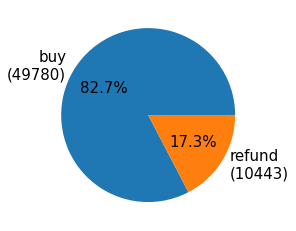

In [82]:
# 순 구매율
p1 = len(df[df['type']=='PAYMENT']) # 총 판매량
p2 = len(df[df['purchased']==True]) # 순 구매량
a = [p2, p1-p2] #순 구매량, 환불량
labels = ['buy'+f'\n({p2})','refund'+f'\n({p1-p2})']
plt.pie(a, labels=labels, autopct='%.1f%%')
plt.show()

**TOP 20**
- 상위 20개 강의가 전체 강의의 30%나 차지하는 것을 알 수 있다.

In [83]:
ctt111 = pt[['course_title','category_title']].value_counts().head(20)

In [84]:
# 가장 많이 구매한 강의 top 20
ctt = pt[['course_title','category_title']].value_counts().head(20)
ctt_lst = []
for i in range(20):
  ctt_lst.append(pt['course_title'].value_counts(normalize=True)[i]*100)

In [85]:
ctt = pd.DataFrame(pt[['course_title','category_title']].value_counts().head(20))
ctt['percent'] = ctt_lst
ctt

0  \
course_title                                       category_title         
초격차 패키지 : 한 번에 끝내는 프론트엔드 개발                        프로그래밍           1363   
초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터             프로그래밍           1357   
초격차 패키지 : 한번에 끝내는 영상 촬영과 편집                        영상/3D           1177   
The RED : 김영하 작가의 내 안의 숨은 이야기를 찾아 쓰는 법             마케팅             1017   
초격차 패키지 : 한 번에 끝내는 node.js 웹 프로그래밍                 프로그래밍            783   
나의 칼퇴치트키 엑셀유치원                                     업무생산성            772   
올인원 패키지 : star741의 캐주얼 일러스트 드로잉                    디자인              648   
초격차 패키지 : 한 번에 끝내는 엑셀 실무                           업무생산성            641   
초격차 패키지 : 한번에 끝내는 디자인 툴                            디자인              636   
올인원 패키지 : 김민태의 프론트엔드 아카데미 : 제 1강 JavaScript & T... 프로그래밍            616   
초격차 패키지 : 한 번에 끝내는 데이터 분석 툴                        데이터사이언스          597   
초격차 패키지 : 한번에 끝내는 UX/UI 디자인                        디자인              591   
초격차 패키지 : 일잘러 필수 스킬 모음.zip                         업무생산성            590   
초격차 패키지 : 30개 프로젝트로 배우는 Android 앱 개발 with Kotlin   프로그래밍            583   
올인원 패키지 : 완전정복 시각디자인 기초                            디자인              581   
초격차 패키지 : 한번에 끝내는 모션그래픽                            영상/3D            544   
초격차 패키지 : 한번에 끝내는 PPT 제작/디자인                       업무생산성            543   
입만 열면 인정받는 스피치 10분컷                                업무생산성            530   
올인원 패키지 : GA4 탑재, 구글 애널리틱스 끝장내기                    마케팅              527   
올인원 패키지 : 디지털 마케팅 MAX 2020                         마케팅              515   

                                                                    percent  
course_title                                       category_title            
초격차 패키지 : 한 번에 끝내는 프론트엔드 개발                        프로그래밍           2.863506  
초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터             프로그래밍           2.850900  
초격차 패키지 : 한번에 끝내는 영상 촬영과 편집                        영상/3D           2.472741  
The RED : 김영하 작가의 내 안의 숨은 이야기를 찾아 쓰는 법             마케팅             2.136600  
초격차 패키지 : 한 번에 끝내는 node.js 웹 프로그래밍                 프로그래밍           1.644993  
나의 칼퇴치트키 엑셀유치원                                     업무생산성           1.621883  
올인원 패키지 : star741의 캐주얼 일러스트 드로잉                    디자인             1.361373  
초격차 패키지 : 한 번에 끝내는 엑셀 실무                           업무생산성           1.346667  
초격차 패키지 : 한번에 끝내는 디자인 툴                            디자인             1.336163  
올인원 패키지 : 김민태의 프론트엔드 아카데미 : 제 1강 JavaScript & T... 프로그래밍           1.294145  
초격차 패키지 : 한 번에 끝내는 데이터 분석 툴                        데이터사이언스         1.254228  
초격차 패키지 : 한번에 끝내는 UX/UI 디자인                        디자인             1.241623  
초격차 패키지 : 일잘러 필수 스킬 모음.zip                         업무생산성           1.239522  
초격차 패키지 : 30개 프로젝트로 배우는 Android 앱 개발 with Kotlin   프로그래밍           1.224816  
올인원 패키지 : 완전정복 시각디자인 기초                            디자인             1.220614  
초격차 패키지 : 한번에 끝내는 모션그래픽                            영상/3D           1.142881  
초격차 패키지 : 한번에 끝내는 PPT 제작/디자인                       업무생산성           1.140780  
입만 열면 인정받는 스피치 10분컷                                업무생산성           1.117671  
올인원 패키지 : GA4 탑재, 구글 애널리틱스 끝장내기                    마케팅             1.107166  
올인원 패키지 : 디지털 마케팅 MAX 2020                         마케팅             1.081956

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


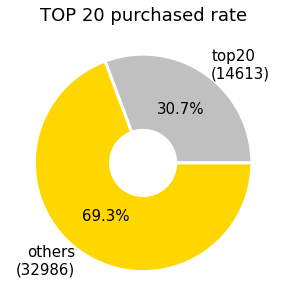

In [86]:
# 상위 20개 강의의 구매 비율 (총 강의 개수 추가해야함)


p1 = sum(pt['course_title'].value_counts()[0:20]) # 상위 20개 구매량
p2 = sum(pt['course_title'].value_counts()[:]) # 전체 구매

a = [p1, p2-p1]
labels = ['top20'+f'\n({p1})','others'+f'\n({p2-p1})']
colors = ['silver', 'gold']
wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 3}
plt.figure(figsize=(5,5))
plt.pie(a, labels=labels, colors=colors, autopct='%.1f%%', wedgeprops=wedgeprops)
plt.title('TOP 20 purchased rate')
plt.show()

**카테고리별 분석**
- 프로그래밍이 가장 큰 비중을 차지하고 있다.
- 상위 3개 카테고리 (프로그래밍, 데이터사이언스, 업무생산성)이 전체 구매 강의의 50% 이상 차지

In [87]:
pt['category_title'].value_counts()

프로그래밍      14907
데이터사이언스     6561
업무생산성       6401
디자인         5397
영상/3D       4898
마케팅         4473
부동산/금융      2710
투자/재테크      1401
크리에이티브       791
지식콘텐츠         23
비즈니스          21
파이낸스          16
Name: category_title, dtype: int64

In [88]:
pt['category_title'].value_counts().index.tolist()

['프로그래밍',
 '데이터사이언스',
 '업무생산성',
 '디자인',
 '영상/3D',
 '마케팅',
 '부동산/금융',
 '투자/재테크',
 '크리에이티브',
 '지식콘텐츠',
 '비즈니스',
 '파이낸스']

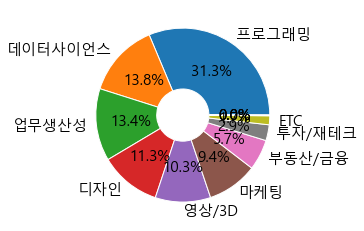

In [125]:
# 카테고리 별 구매율
b = pt['category_title'].value_counts()

labels = ['프로그래밍','데이터사이언스','업무생산성','디자인',
 '영상/3D', '마케팅', '부동산/금융', '투자/재테크', 'ETC','','',''] 
# 가독성 문제로 '크리에이티브','지식콘텐츠','비즈니스','파이낸스' -> ETC로 대체
wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}
plt.pie(b, labels=labels, autopct='%.1f%%', wedgeprops=wedgeprops)
plt.show()

### VIP

#### VIP 선정 기준
- 구매량이 많은 순으로 선정하려 했으나, 강의를 1,2개만 구매했는데 100만원 이상 구매한 고객도 있고, 반대의 경우도 있었음
- 'revenue' 값이 50만원 이상일 경우, 약 1300개의 값이 나오고, 전체 구매자 수의 3.5% 가량이므로 vip의 기준으로 선정

In [90]:
t = pt.groupby("customer_id").agg({"revenue": "sum","id":'count'}).sort_values(by=["id","revenue"], ascending=False)
t

revenue  id
customer_id               
98685        7040750.0  53
50769        4979110.0  39
40783        4424095.0  34
65665        2958900.0  27
20784        3445050.0  26
...                ...  ..
648707             0.0   1
651365             0.0   1
653145             0.0   1
653319             0.0   1
665031             0.0   1

[36024 rows x 2 columns]

In [91]:
# 단순 구매량
t.id.value_counts(ascending=True)

53        1
39        1
34        1
27        1
26        1
22        1
21        1
19        1
18        1
17        1
16        2
14        4
15        4
13        5
12        7
11        9
10       16
9        16
8        39
7        61
6       127
5       217
4       444
3      1219
2      4760
1     29084
Name: id, dtype: int64

In [92]:
# 강의 개수에 대한 누적 구매량
# 갯수 상위 20% : 2개이상 구매
# 갯수 상위 6% : 3개이상 구매
# 갯수 상위 2.5% : 4개이상 구매
cum_t = t.id.value_counts(ascending=True).cumsum()
cum_t = cum_t / cum_t.iloc[-1] * 100
cum_t

53      0.002776
39      0.005552
34      0.008328
27      0.011104
26      0.013880
22      0.016656
21      0.019431
19      0.022207
18      0.024983
17      0.027759
16      0.033311
14      0.044415
15      0.055519
13      0.069398
12      0.088830
11      0.113813
10      0.158228
9       0.202643
8       0.310904
7       0.480235
6       0.832778
5       1.435154
4       2.667666
3       6.051521
2      19.264934
1     100.000000
Name: id, dtype: float64

In [93]:
# 강의 구매 개수 별 누적 구매 금액 1 
t_trans = t.groupby("id").agg({"revenue": "sum"}).sort_values(by=["id"], ascending=False)
t_trans

revenue
id              
53  7.040750e+06
39  4.979110e+06
34  4.424095e+06
27  2.958900e+06
26  3.445050e+06
22  2.866350e+06
21  3.327550e+06
19  2.958000e+06
18  2.986500e+06
17  2.796000e+06
16  3.724300e+06
15  5.715460e+06
14  6.803800e+06
13  8.618600e+06
12  1.110260e+07
11  1.150155e+07
10  1.727335e+07
9   1.496530e+07
8   3.389246e+07
7   4.962882e+07
6   9.783269e+07
5   1.283224e+08
4   2.158492e+08
3   4.452684e+08
2   1.164469e+09
1   3.963493e+09

In [94]:
# 강의 구매 개수 별 누적 구매 금액 2 
# 상위 20% : 36% 구매
# 상위 6% : 17.5% 구매
# 상위 2.5% : 10% 구매
cum_t = t_trans.cumsum()
cum_t = cum_t / cum_t.iloc[-1] * 100
cum_t

revenue
id            
53    0.113264
39    0.193362
34    0.264532
27    0.312132
26    0.367552
22    0.413662
21    0.467192
19    0.514777
18    0.562821
17    0.607800
16    0.667712
15    0.759656
14    0.869108
13    1.007754
12    1.186361
11    1.371385
10    1.649259
9     1.890004
8     2.435229
7     3.233602
6     4.807425
5     6.871733
4    10.344075
3    17.507057
2    36.239735
1   100.000000

In [95]:
t["revenue"].sort_values(ascending=False)[:len(t)//20]

customer_id
98685     7040750.0
50769     4979110.0
40783     4424095.0
20784     3445050.0
72501     3327550.0
            ...    
501492     442000.0
74884      442000.0
167361     442000.0
87515      441500.0
447444     441300.0
Name: revenue, Length: 1801, dtype: float64

- 실제 수익에서 상위 5퍼의 마지막 value를 찾음

In [96]:
t2 = t[(t["revenue"]>=500000)].sort_values(by=["revenue", "id"], ascending=False)
t2

revenue  id
customer_id               
98685        7040750.0  53
50769        4979110.0  39
40783        4424095.0  34
20784        3445050.0  26
72501        3327550.0  21
...                ...  ..
121701        500000.0   2
666982        500000.0   2
27867         500000.0   1
79817         500000.0   1
138597        500000.0   1

[1322 rows x 2 columns]

- **50만원을 기준으로 나누었을 때, 전체 고객 중 vip 고객의 비율이 3.6%

In [97]:
print(f"상위 {round((len(t2)/len(t))*100, 2)}%")

상위 3.67%


In [98]:
# 구매금액 500000원 이상 골라내기
t = pt.groupby("customer_id").agg({"revenue": "sum","id":'count'}).sort_values(by=["revenue", "id"], ascending=False)
t[t["revenue"]>500000]

revenue  id
customer_id               
98685        7040750.0  53
50769        4979110.0  39
40783        4424095.0  34
20784        3445050.0  26
72501        3327550.0  21
...                ...  ..
268963        501300.0   3
170809        501000.0   3
423264        500800.0   5
420389        500500.0   2
539780        500500.0   2

[1315 rows x 2 columns]

In [99]:
# 조건을 만족하는 값들 모아 'vip' column 생성
t2 = t[(t["revenue"]>=500000)].sort_values(by=["revenue", "id"], ascending=False)

def func(x):
    if x in t2.index:
        return True
    else:
        return False

pt['vip'] = pt["customer_id"].apply(func)

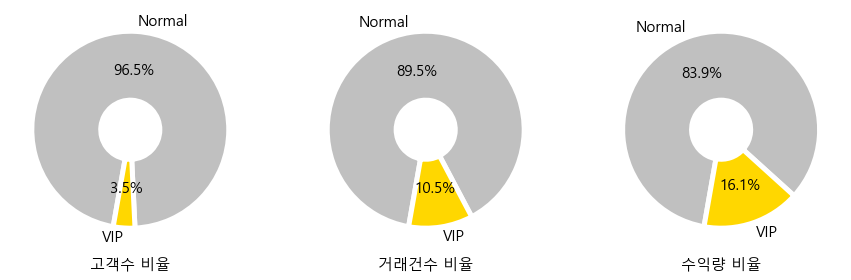

In [126]:
# VIP 특징

t3 = pt.groupby("vip").agg({"id": "count", "transaction_amount": "sum"})

plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
plt.pie([len(t), len(t2)], labels=["Normal", "VIP"], autopct='%.1f%%', startangle=260, colors=colors, counterclock=False, wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})
plt.xlabel("고객수 비율")

plt.subplot(1,3,2)
plt.pie(t3['id'], labels=["Normal", "VIP"], autopct='%.1f%%', startangle=260, colors=colors, counterclock=False, wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})
plt.xlabel("거래건수 비율")

plt.subplot(1,3,3)
plt.pie(t3['transaction_amount'], labels=["Normal", "VIP"], autopct='%.1f%%', startangle=260, colors=colors, counterclock=False, wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 5})
plt.xlabel("수익량 비율")

plt.show()

- vip 고객이 일반 고객보다 수익이 약 5배정도 많음
- 일반 고객이 전체 수익의 84.2%를 차지


**판매 전략**

1. 일반 고객을 vip로 만드는 전략 (순빈, 진규)
2. 일반 고객을 늘리는 전략 (지훈, 현규)
3. 기타 고객 (B2B,B2G) 늘리는 전략 (치현)
->> vip와 일반 고객의 차이 조사 (vip 특성), 늘리는 전략 생각 (일반 고객 특징) + B2B & B2G

In [101]:
from collections import Counter

con = Counter(pt['customer_id']).most_common()

In [102]:
pt[pt['customer_id']==con[2][0]]

id  customer_id  course_id     type      state  \
15072  1016413        40783        NaN  PAYMENT  COMPLETED   
15083  1016440        40783        NaN  PAYMENT  COMPLETED   
18195  1027066        40783   202284.0  PAYMENT  COMPLETED   
18196  1027068        40783   201849.0  PAYMENT  COMPLETED   
18199  1027075        40783   203940.0  PAYMENT  COMPLETED   
18202  1027081        40783   201798.0  PAYMENT  COMPLETED   
18367  1027612        40783   203525.0  PAYMENT  COMPLETED   
18372  1027622        40783   203782.0  PAYMENT  COMPLETED   
18381  1027642        40783   203499.0  PAYMENT  COMPLETED   
18390  1027657        40783   203845.0  PAYMENT  COMPLETED   
22401  1038474        40783   200328.0  PAYMENT  COMPLETED   
28713  1056216        40783   203535.0  PAYMENT  COMPLETED   
50174  1126111        40783   203100.0  PAYMENT  COMPLETED   
50182  1126130        40783   201997.0  PAYMENT  COMPLETED   
50186  1126138        40783   203989.0  PAYMENT  COMPLETED   
50289  1126464        40783   202663.0  PAYMENT  COMPLETED   
57135  1151774        40783   203180.0  PAYMENT  COMPLETED   
57143  1151793        40783   203942.0  PAYMENT  COMPLETED   
57146  1151797        40783   204068.0  PAYMENT  COMPLETED   
64095  1176485        40783   205625.0  PAYMENT  COMPLETED   
64096  1176495        40783   205440.0  PAYMENT  COMPLETED   
64101  1176519        40783   205707.0  PAYMENT  COMPLETED   
69291  1196154        40783   205925.0  PAYMENT  COMPLETED   
69294  1196161        40783   204631.0  PAYMENT  COMPLETED   
75188  1224199        40783   205222.0  PAYMENT  COMPLETED   
78753  1239297        40783   204373.0  PAYMENT  COMPLETED   
81975  1253565        40783   205570.0  PAYMENT  COMPLETED   
81978  1253573        40783   205640.0  PAYMENT  COMPLETED   
81979  1253577        40783   204706.0  PAYMENT  COMPLETED   
81980  1253579        40783   202932.0  PAYMENT  COMPLETED   
82281  1255404        40783   205578.0  PAYMENT  COMPLETED   
86087  1274766        40783   202712.0  PAYMENT  COMPLETED   
99654  1335029        40783   205041.0  PAYMENT  COMPLETED   
99655  1335032        40783   206720.0  PAYMENT  COMPLETED   

                                            course_title category_title  \
15072      프로모션 : 콘텐츠 디자이너를 위한 커리어 백과사전 무제한 패스 (4월 프리패스)         크리에이티브   
15083            프로모션 : 기초부터 시작하는 데이터분석 무제한 패스 (4월 프리패스)        데이터사이언스   
18195                        올인원 패키지 : 검색 최적화(SEO) 운영/전략            마케팅   
18196                                  올인원 패키지 : 그로스 마케팅            마케팅   
18199                            올인원 패키지 : 데이터 기반 마케팅 21            마케팅   
18202                                 올인원 패키지 : 브랜딩 2020            마케팅   
18367             초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터          프로그래밍   
18372                            초격차 패키지 : 한번에 끝내는 모션그래픽          영상/3D   
18381                    올인원 패키지 : 100억을 움직이는 단 10장의 PPT          업무생산성   
18390         올인원 패키지 : 연봉도 배우면 바뀐다! 협상왕의 12가지 시스템 불패 전략          업무생산성   
22401                                 올인원 패키지 : 파이썬 웹 개발          프로그래밍   
28713                       초격차 패키지 : 한번에 끝내는 PPT 제작/디자인          업무생산성   
50174          올인원 패키지 : 성공적인 UX를 위한 유저 리서치 by 카카오페이 리서처            디자인   
50182                             올인원 패키지 : Android 앱 개발          프로그래밍   
50186                 올인원 패키지 : 소금툰과 함께 캐릭터 드로잉/굿즈/임티/컷툰            디자인   
50289                          올인원 패키지 : 소비자 리서치와 보고서 작성            마케팅   
57135             The RED : 지브리 스튜디오 제작국장에게 듣는 스토리텔링 기획법            마케팅   
57143   초격차 패키지 : 30개 프로젝트로 배우는 Android 앱 개발 with Kotlin          프로그래밍   
57146                         올인원 패키지 : 마디아의 UX/UI 포트폴리오            디자인   
64095                       초격차 패키지 : 세상의 모든 감성 아이패드 드로잉            디자인   
64096                          초격차 패키지 : 한 번에 끝내는 포토샵 활용            디자인   
64101     올인원 패키지 : 15명의 전문 애널리스트에게 배우는 산업&매크로 분석과 투자 전략         투자/재테크   
69291      [런칭프로모션_무료클립제공]초격차 패키지 : 한 번에 끝내는 React의 모든 것          프로그래밍   
69294                 초격차 패키지 : 한 번에 끝내는 

### 수강생을 늘리기 위한 효과적인 마케팅 방법 분석 ( vip가 아닌 고객 대상)

#### format 분석

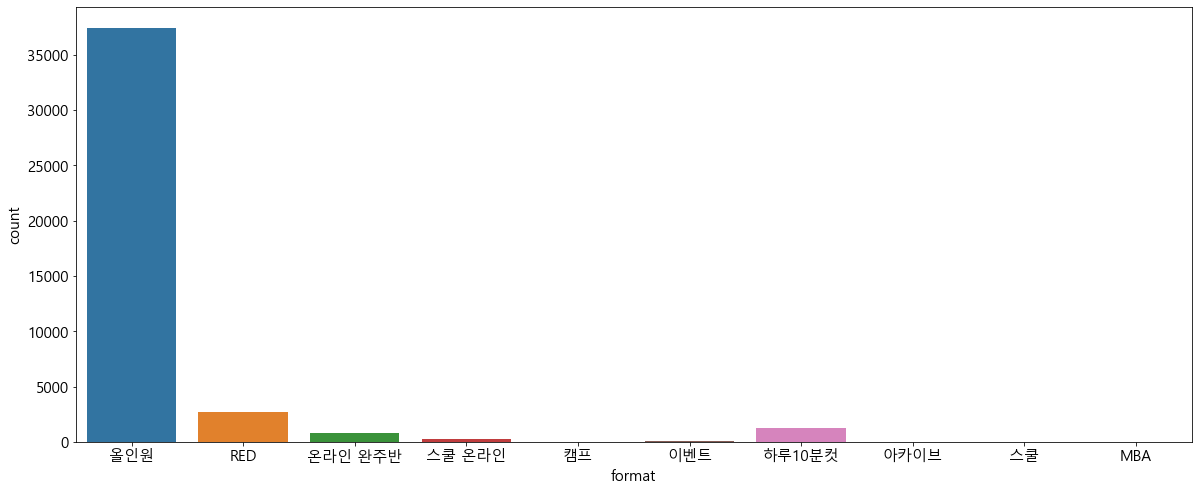

In [127]:
plt.figure(figsize=(20,8))
sns.countplot(x=pt[pt['vip']==False]['format'],data=pt)
plt.show()

- 올인원의 인기가 가장 많음
- 올인원에 속한 강의나 카테고리 확인해보기

In [104]:
all_cnt = pt[(pt['vip']==False)&(pt['format']=='올인원')]['category_title']

<AxesSubplot:xlabel='category_title', ylabel='count'>

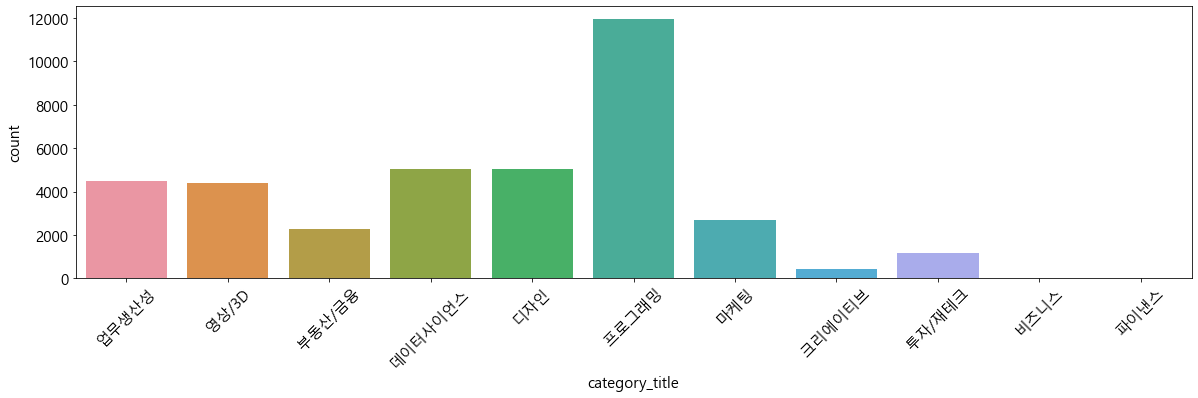

In [128]:
plt.figure(figsize=(20,5))
plt.xticks(rotation = 45)
sns.countplot(x=all_cnt,data=pt)

- 프로그래밍이 다른 카테고리에 비해 2~3배 이상 구매율이 좋다
- 많은 수강생이 프로그래밍에 관심이 있다고 생각되며, 프로그래밍 카테고리의 다른 강의를 판매한다면 다른 카테고리에 비해 더 많은 구매율을 얻을 수 있을 것이라 판단됨.

- 프로그래밍 강의 중에서 세부적으로 확인을 해볼 필요가 있다고 생각함.

<AxesSubplot:xlabel='subcategory_title', ylabel='count'>

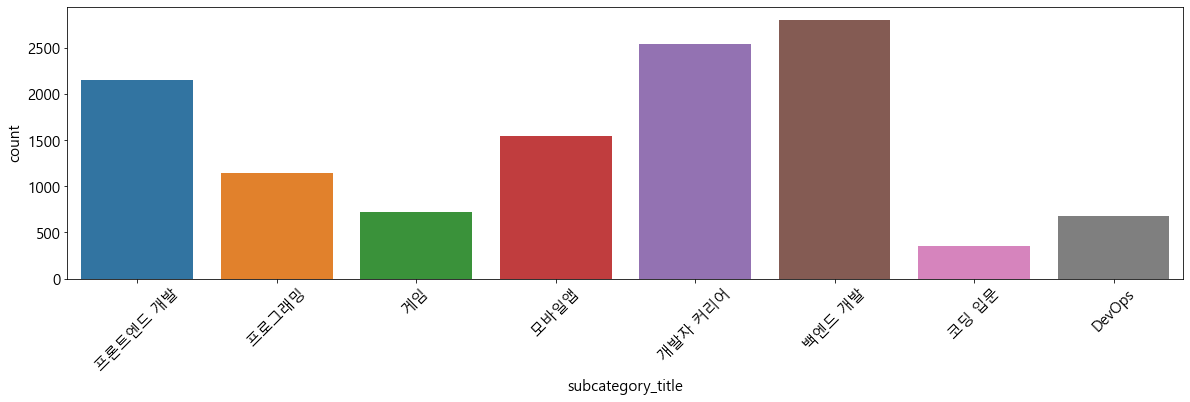

In [129]:
sub_cnt = pt[(pt['vip']==False)&(pt['format']=='올인원')&(pt['category_title']=='프로그래밍')]['subcategory_title']

plt.figure(figsize=(20,5))
plt.xticks(rotation = 45)
sns.countplot(x=sub_cnt,data=pt)

- 위 그래프로 보아 어느정도 프로그래밍에 대해 이미 알고 강의를 구매하는 수강생이 주를 이루는 것으로 보인다.
- 강의영상의 방향성도 알 수 있을 것 같다.

#### completed_at 분석

In [107]:
# 날짜를 일 단위까지 정리하기.
def func(x):
    return x.strftime("%Y-%m-%d")

pt["completed_at"] = pt["completed_at"].apply(func)

<AxesSubplot:xlabel='completed_at', ylabel='count'>

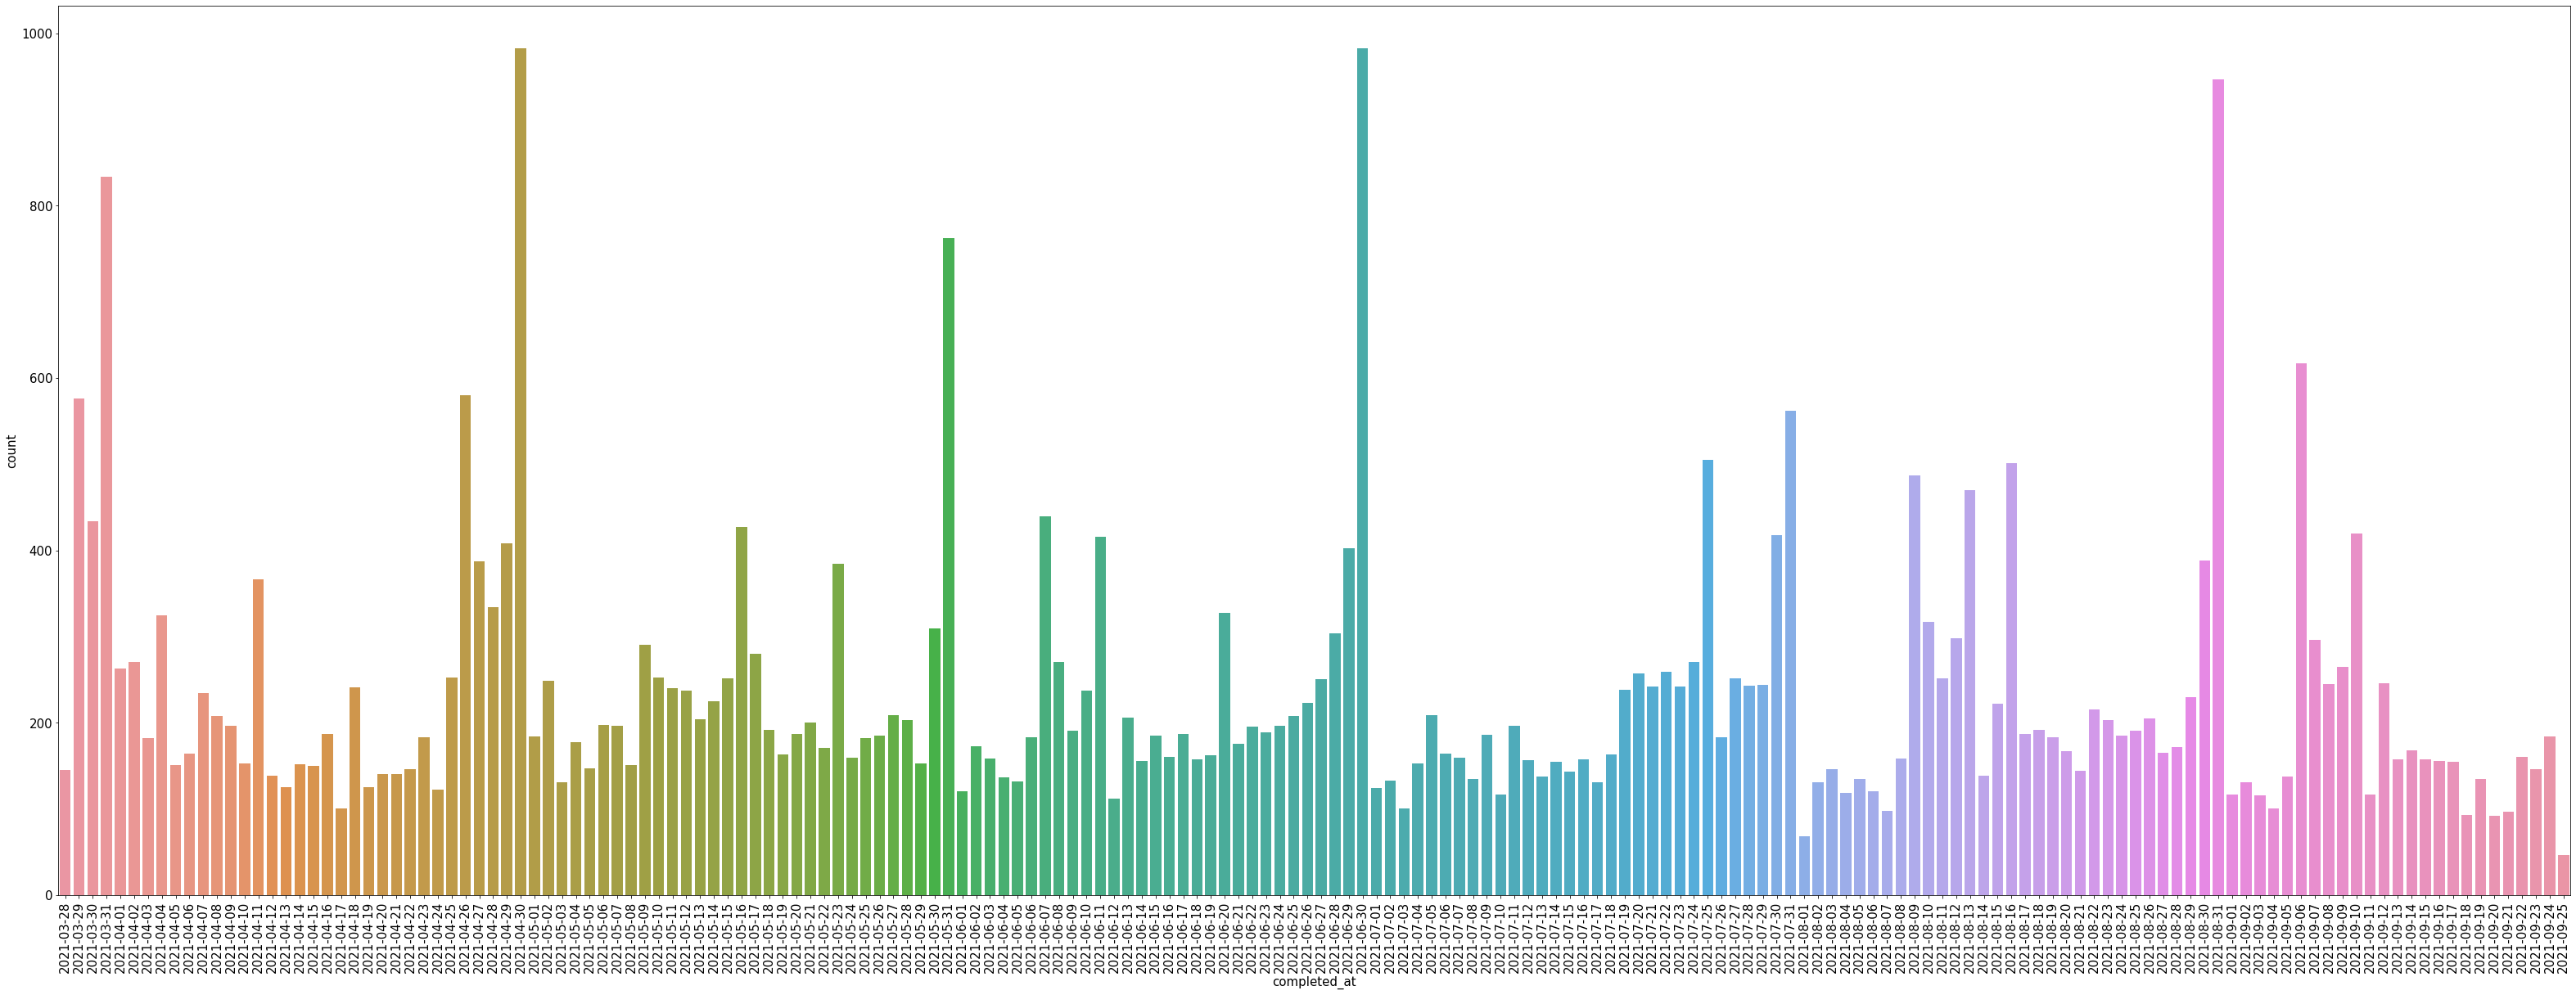

In [108]:
plt.figure(figsize=(55,20))
plt.xticks(rotation = 90)
sns.countplot(x=pt[pt['vip']==False]['completed_at'],data=pt)

- 매달 말에 아주 높은 구매 그래프를 확인 할 수 있다.
- 매달 말에 구매율이 높은 이유 찾기

#### coupon_title 분석

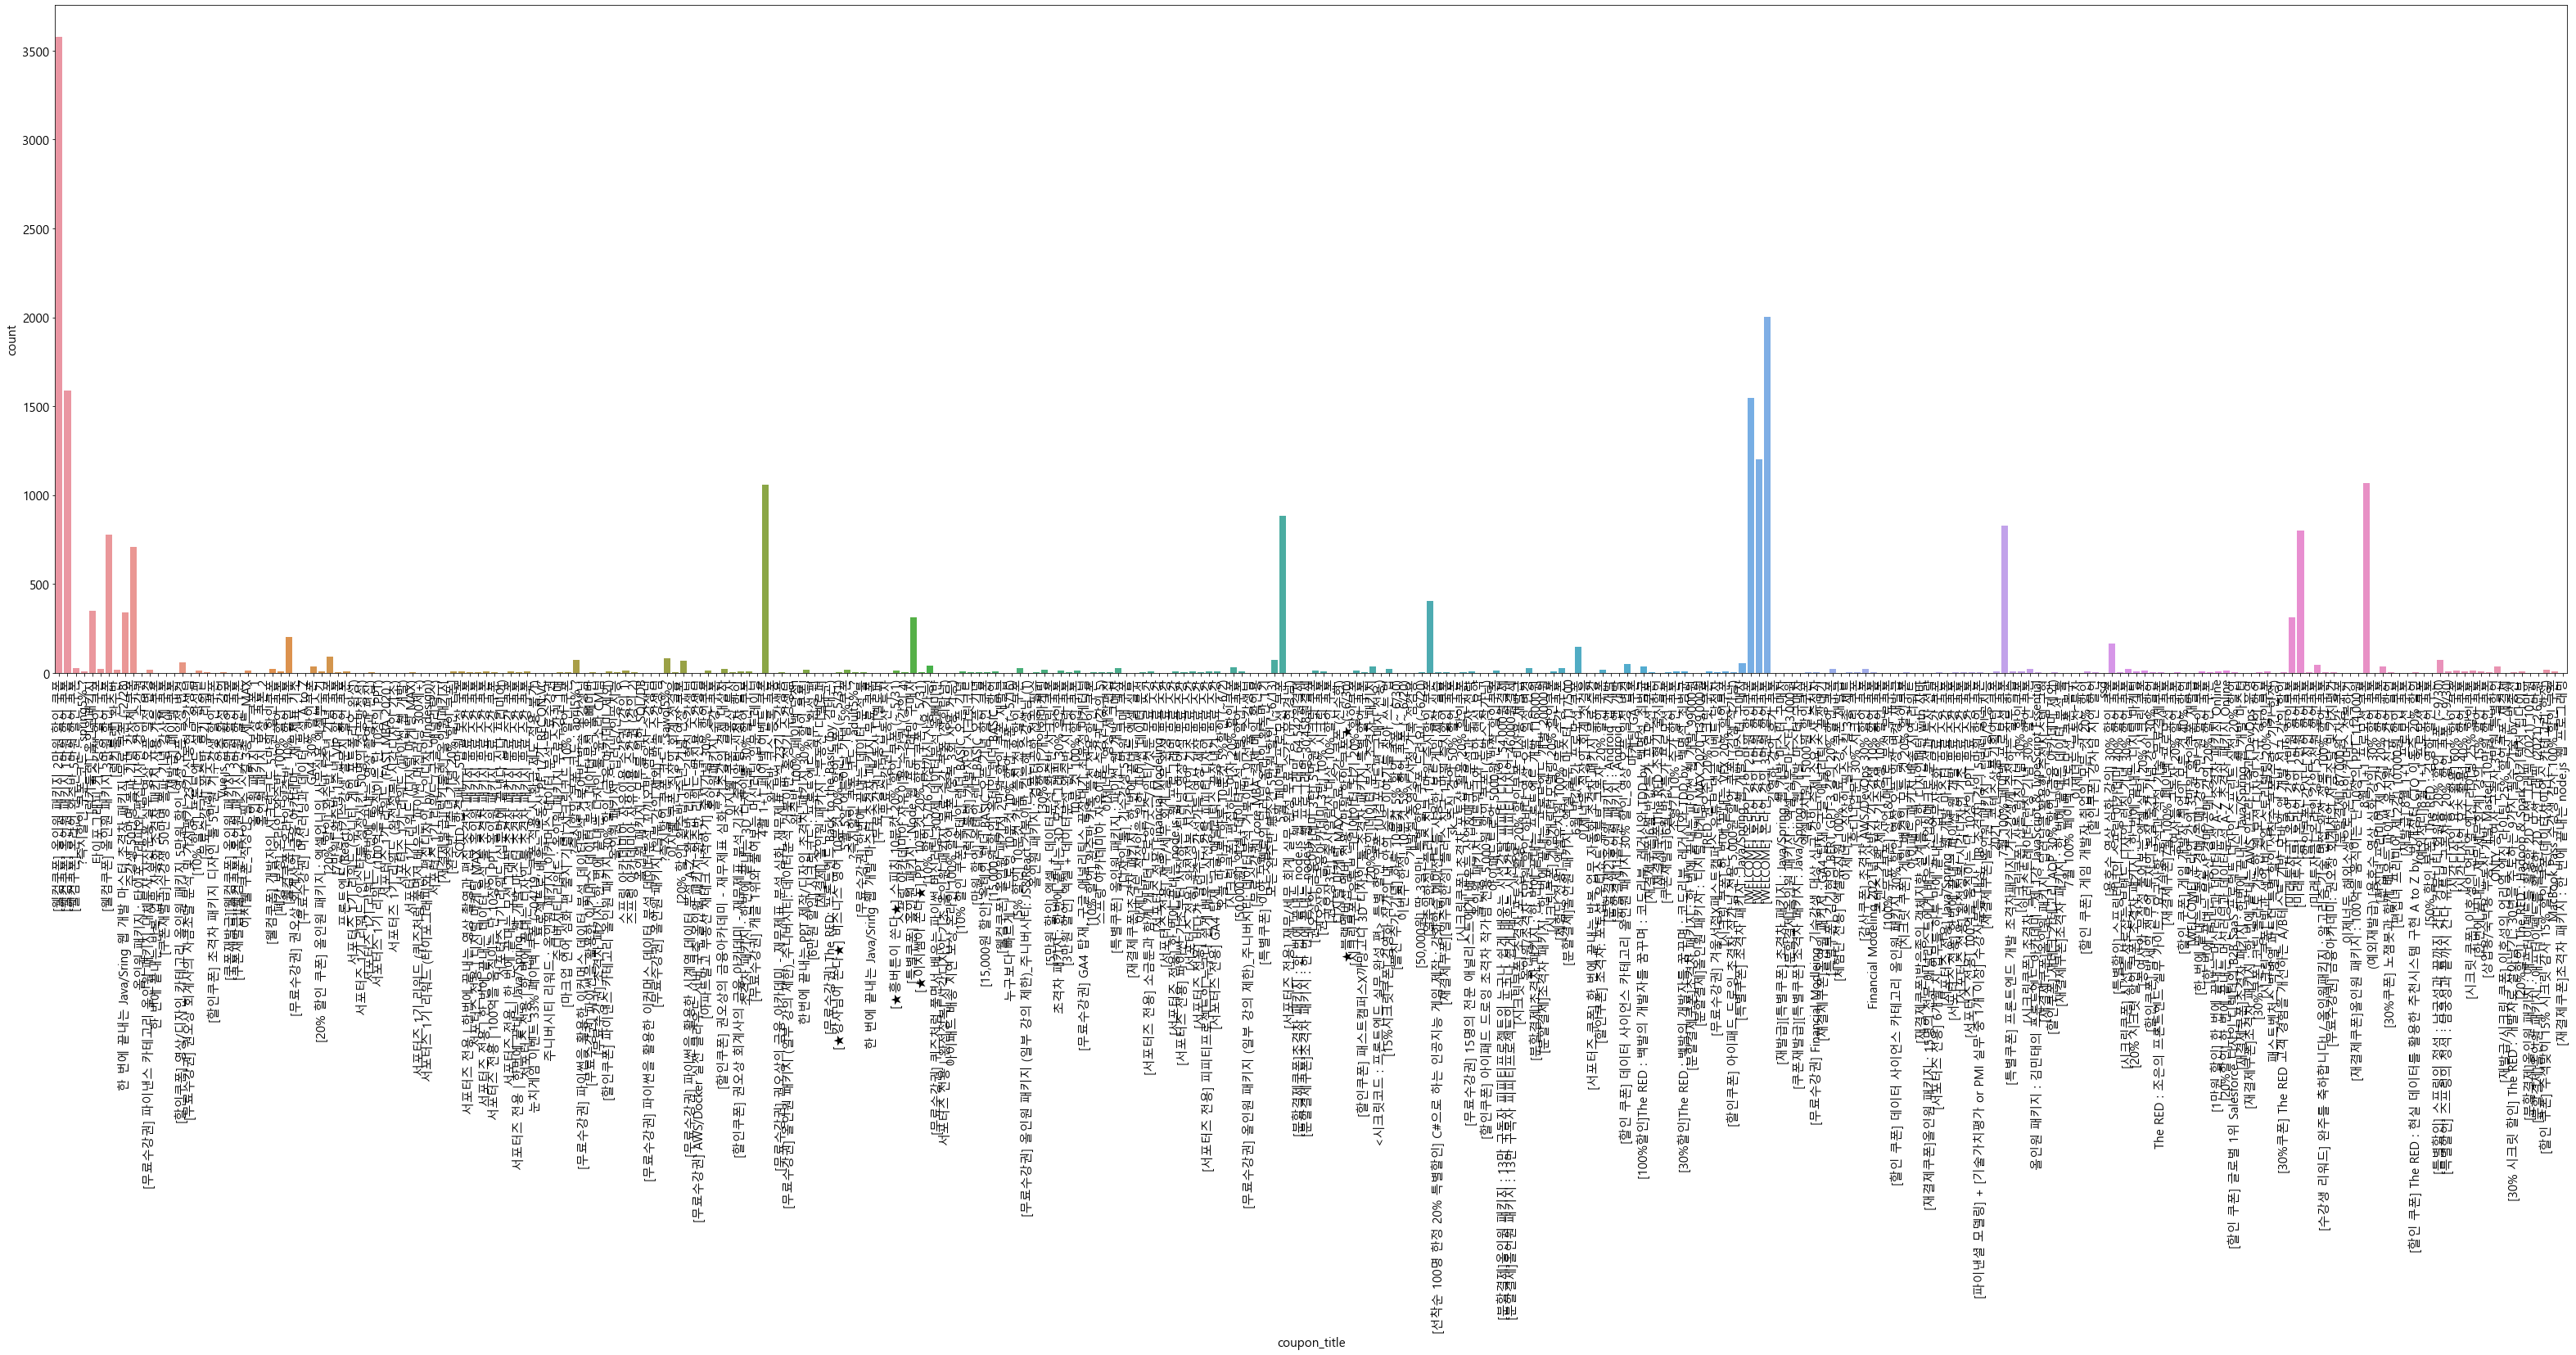

In [130]:
plt.figure(figsize=(55,15))
plt.xticks(rotation = 90)
sns.countplot(x=pt[pt['vip']==False]['coupon_title'],data=pt)
plt.show()

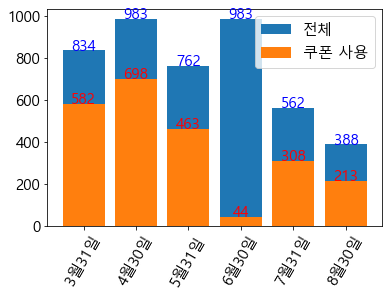

In [131]:
x= [] # 날짜
y= [] # 총 구매량
y1= [] # 쿠폰사용 구매량
for i in range(3,9):
    if i%2 ==0:
        x.append(f'{i}월30일')
        y.append(len(pt[(pt['vip']==False)&(pt['completed_at']==f'2021-0{i}-30')]))
        y1.append(len(pt[(pt['vip']==False)&(pt['completed_at']==f'2021-0{i}-30')].dropna(subset=['coupon_title'])))
    else:
        x.append(f'{i}월31일')
        y.append(len(pt[(pt['vip']==False)&(pt['completed_at']==f'2021-0{i}-31')]))
        y1.append(len(pt[(pt['vip']==False)&(pt['completed_at']==f'2021-0{i}-31')].dropna(subset=['coupon_title'])))
        
bar1 = plt.bar(x,y, label= "전체")
bar2 = plt.bar(x,y1, label= "쿠폰 사용")
plt.xticks(rotation=60)
plt.legend()

for idx, rect in enumerate(bar1):
    plt.text(idx, rect.get_height()+ 0.5,y[idx], ha= 'center', color= 'blue')
    
for idx, rect in enumerate(bar2):
    plt.text(idx, rect.get_height()+ 0.5,y1[idx], ha= 'center', color= 'red')

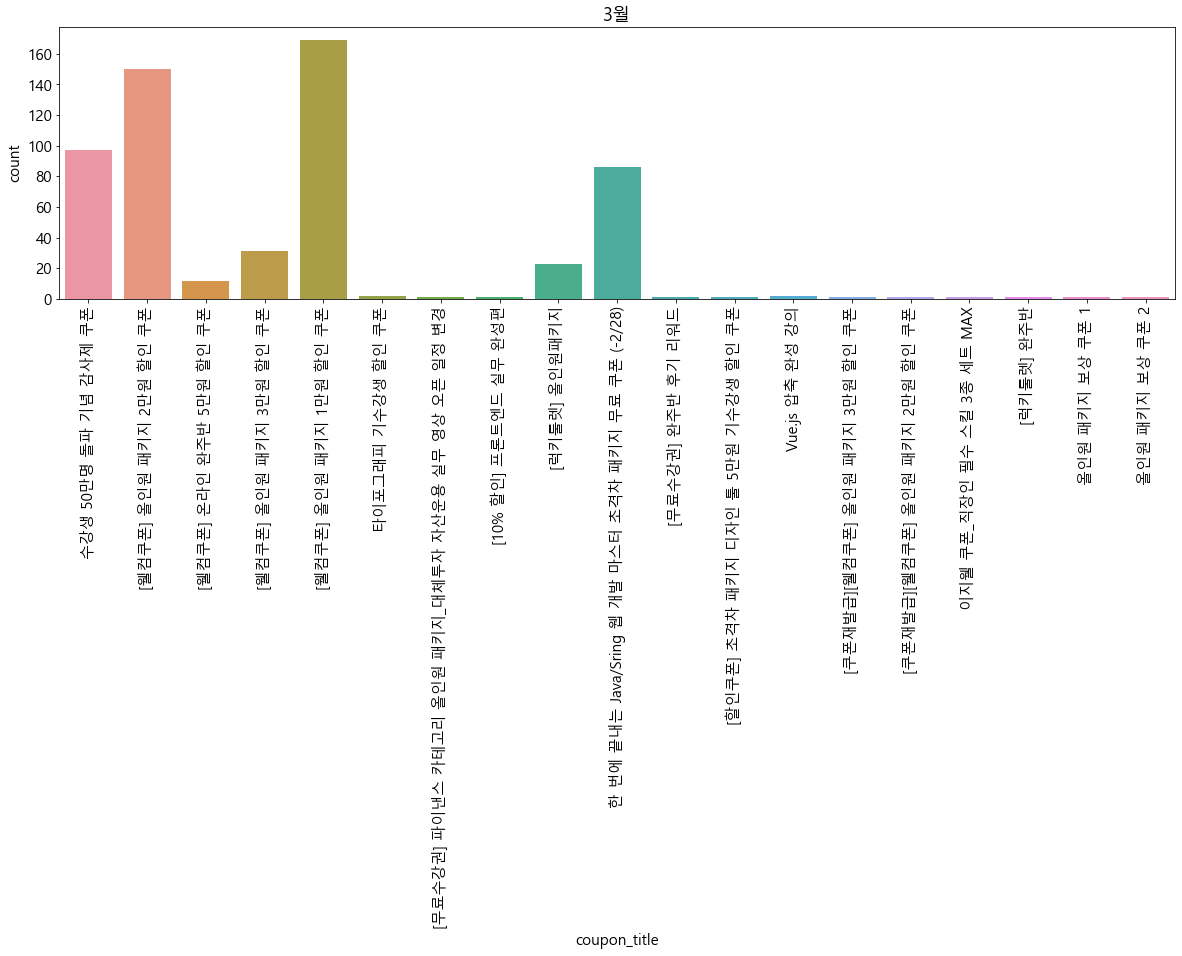

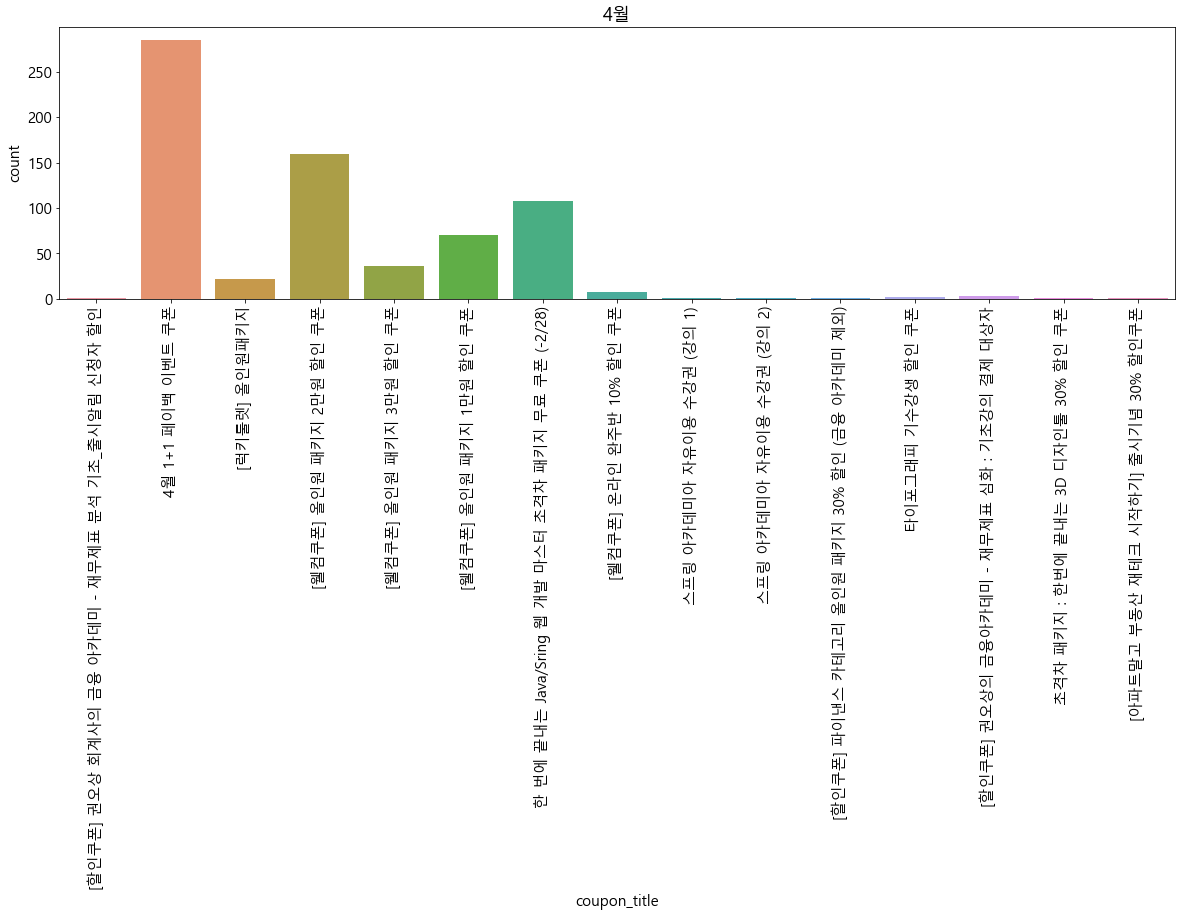

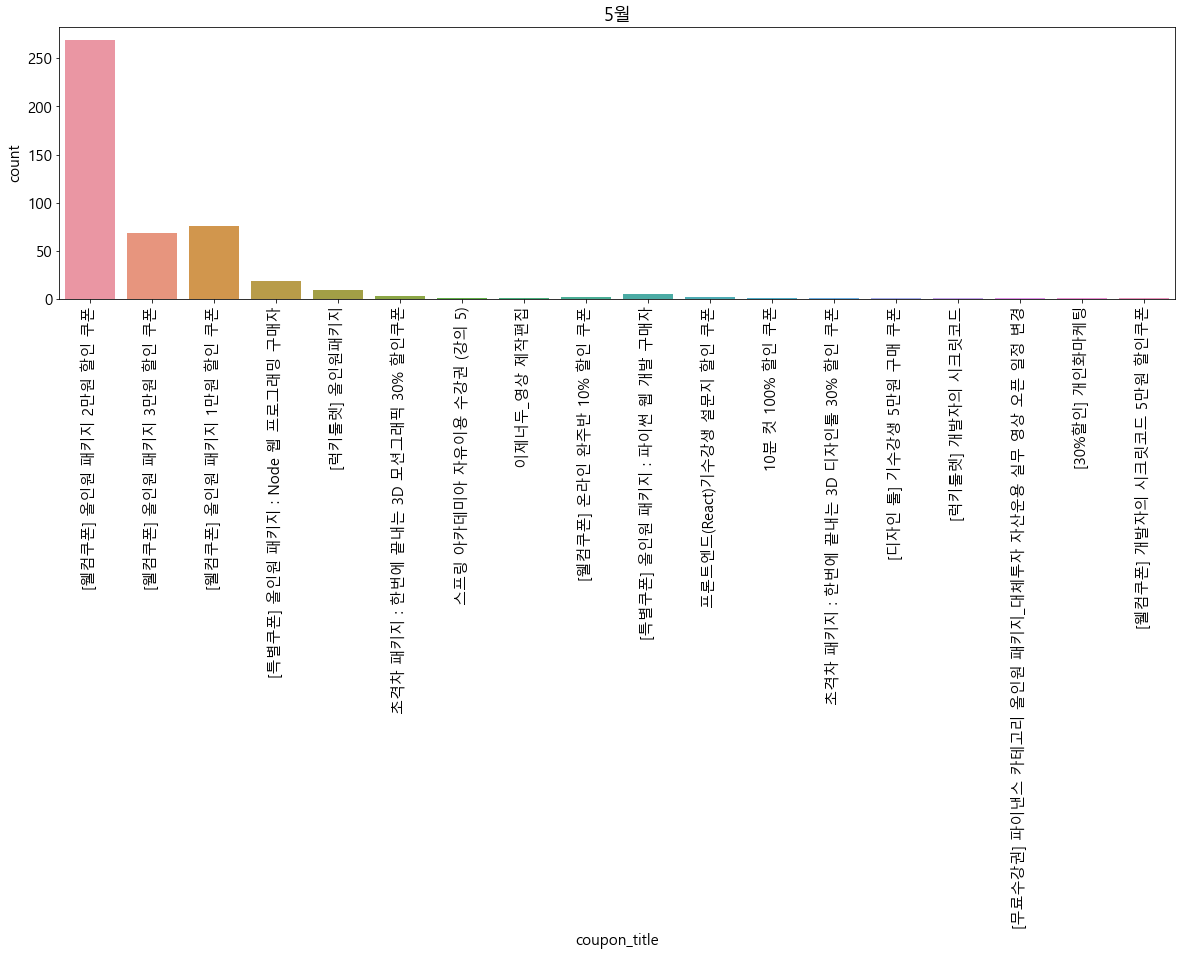

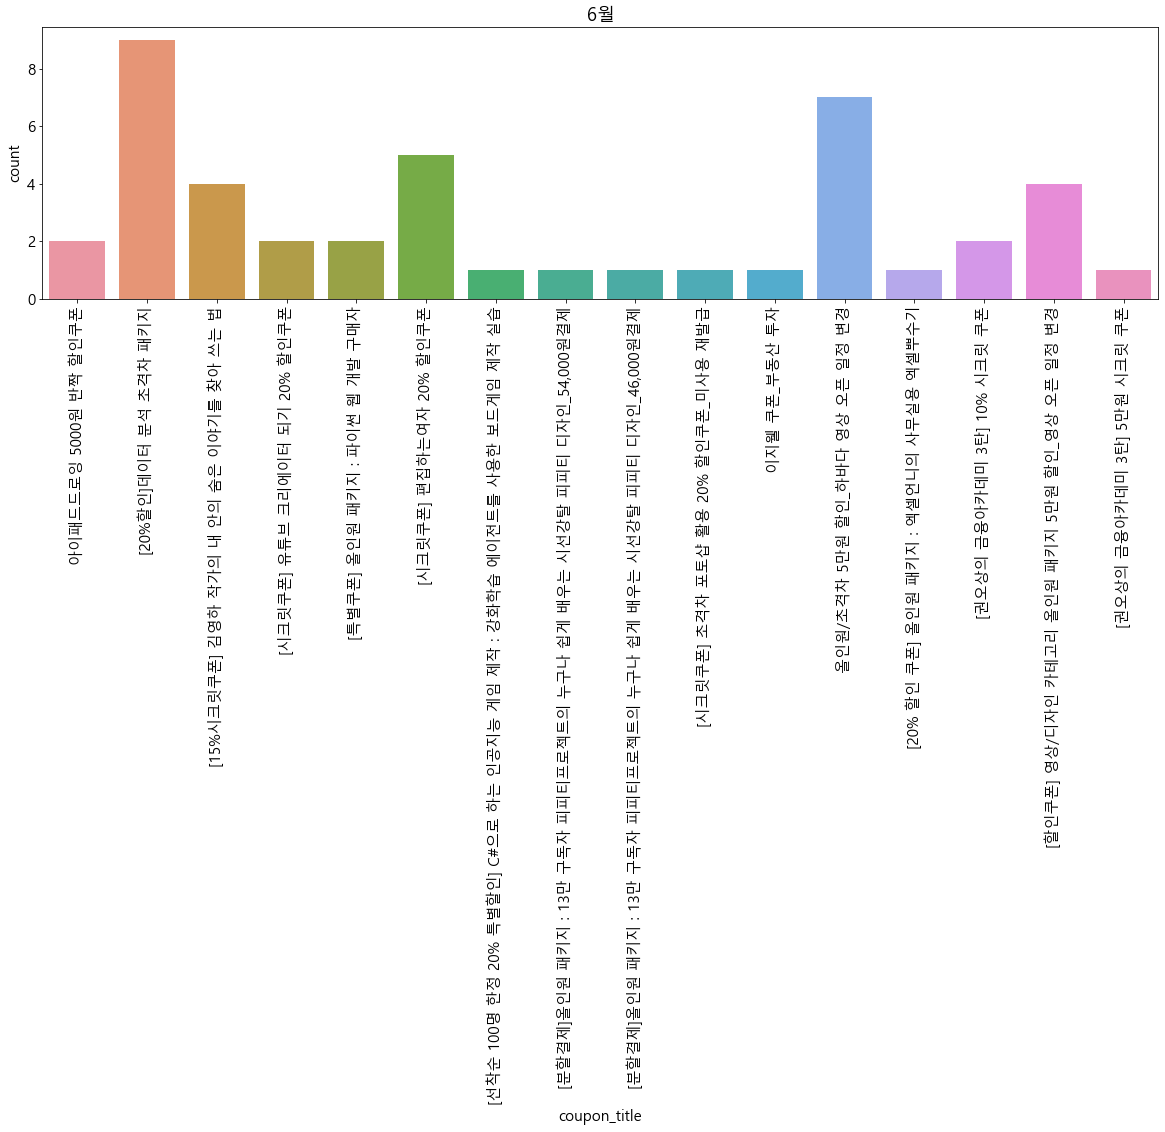

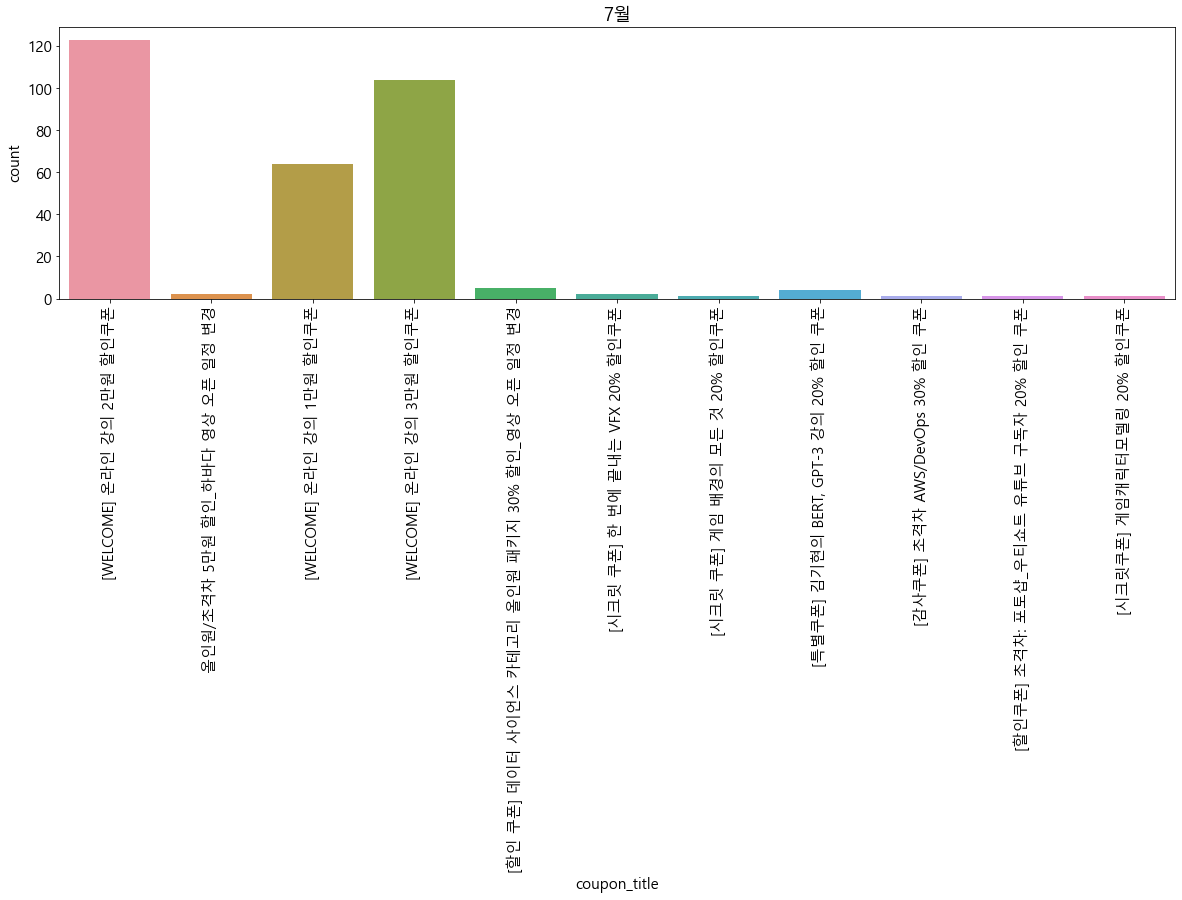

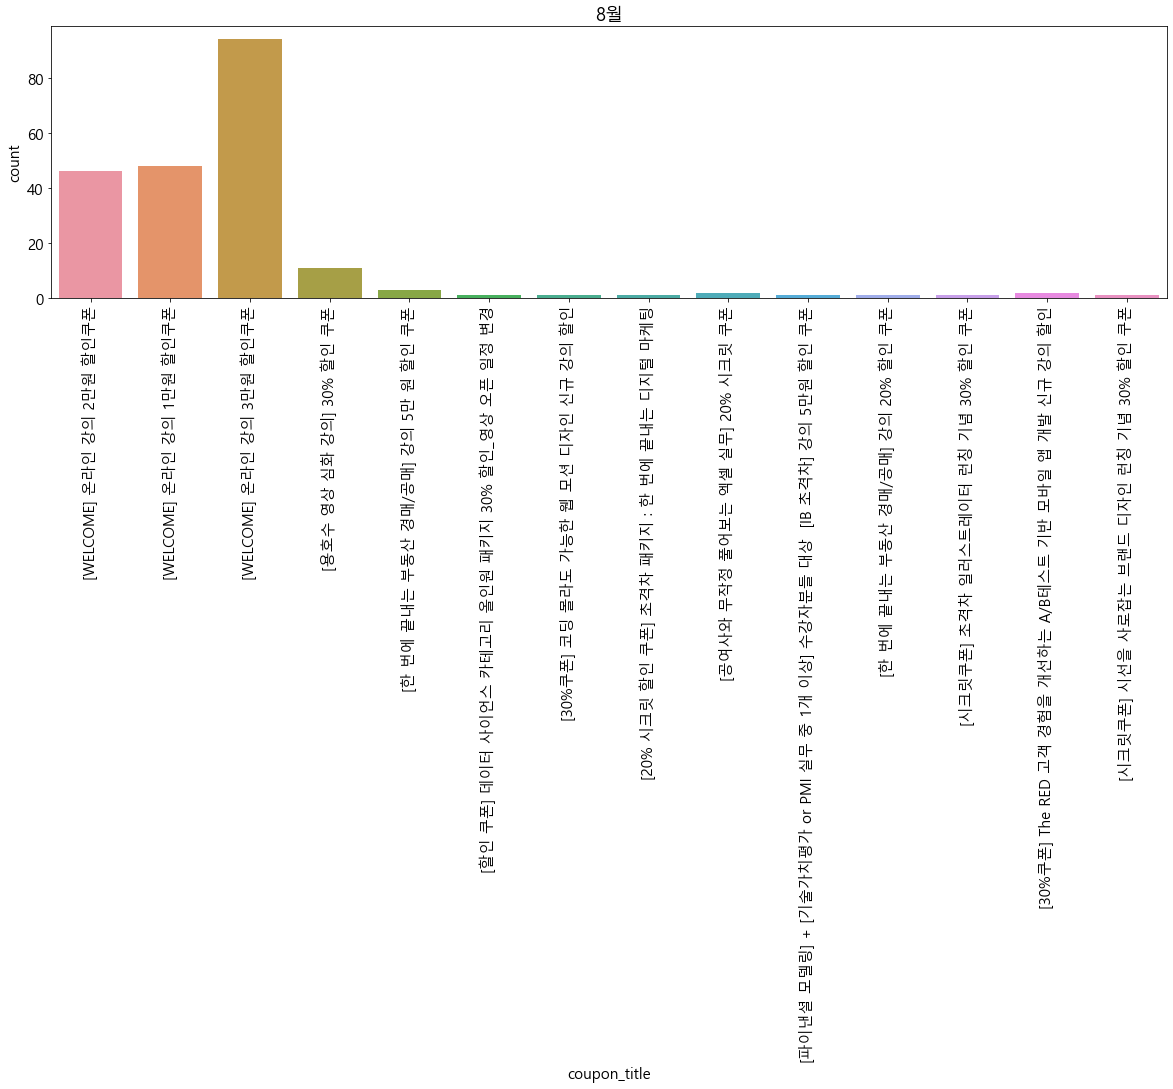

In [132]:
for i in range(3,9):
    plt.figure(figsize=(20,5))
    plt.xticks(rotation = 90)
    plt.title(f'{i}월')
    if i%2 == 0:
        sns.countplot(x=pt[(pt['vip']==False)&(pt['completed_at']==f'2021-0{i}-30')]['coupon_title'],data=pt[(pt['vip']==False)&(pt['completed_at']==f'2021-0{i}-30')])
    else:
        sns.countplot(x=pt[(pt['vip']==False)&(pt['completed_at']==f'2021-0{i}-31')]['coupon_title'],data=pt[(pt['vip']==False)&(pt['completed_at']==f'2021-0{i}-31')])

-  6월 말의 경우 가장 높은 판매량을 기록했지만 그에 비해 쿠폰사용량은 제일 적다. 
- 위 그래프로 보아 쿠폰이 구매의 영향을 끼치지 않을 수 있다 라는 생각이 들지만 위 분석으로 판단하기에 섣부름.
- 달 단위로 데이터를 정리하여 구매와 쿠폰사용의 관계 확인

#### 달 단위 completed_at 과 coupon_title의 관계 분석

In [112]:
# 결제 데이터 달단위 분석.(따로 카피데이터 사용)
import copy

mon = copy.copy(pt)

In [113]:
def func_m(x):
    return x[:7]

mon["completed_at"] = mon["completed_at"].apply(func_m)

In [114]:
mon['completed_at']

2         2021-03
4         2021-03
8         2021-03
10        2021-03
18        2021-03
           ...   
105411    2021-09
105412    2021-09
105413    2021-09
105416    2021-09
105418    2021-09
Name: completed_at, Length: 47599, dtype: object

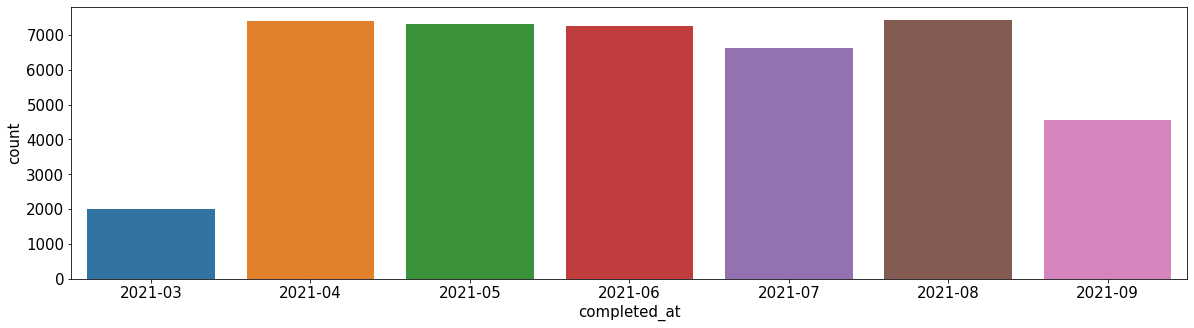

In [115]:
plt.figure(figsize=(20,5))
sns.countplot(x=mon[mon['vip']==False]['completed_at'],data=mon)
plt.show()

In [116]:
mon[mon['vip']==False]['completed_at']

4         2021-03
8         2021-03
10        2021-03
18        2021-03
22        2021-03
           ...   
105411    2021-09
105412    2021-09
105413    2021-09
105416    2021-09
105418    2021-09
Name: completed_at, Length: 42592, dtype: object

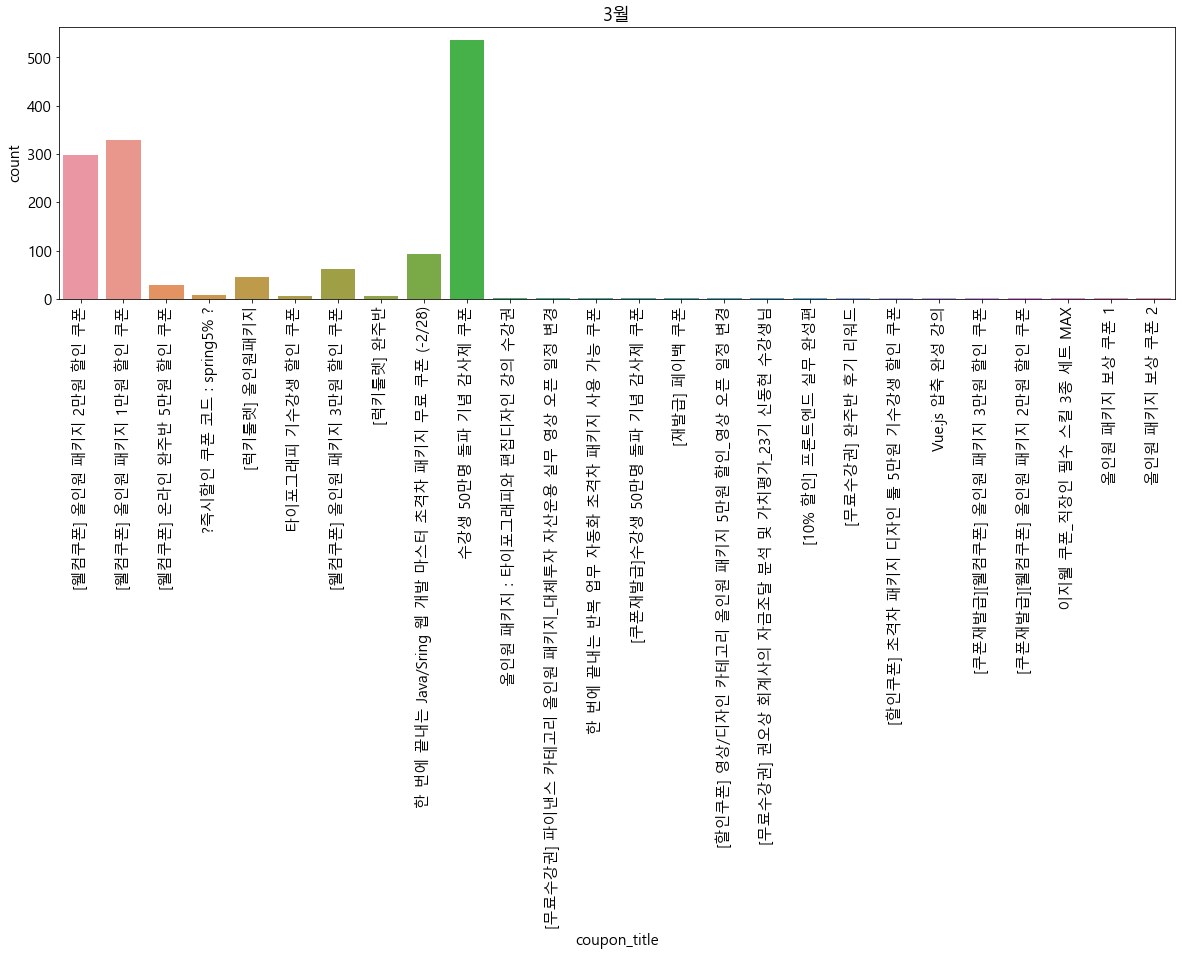

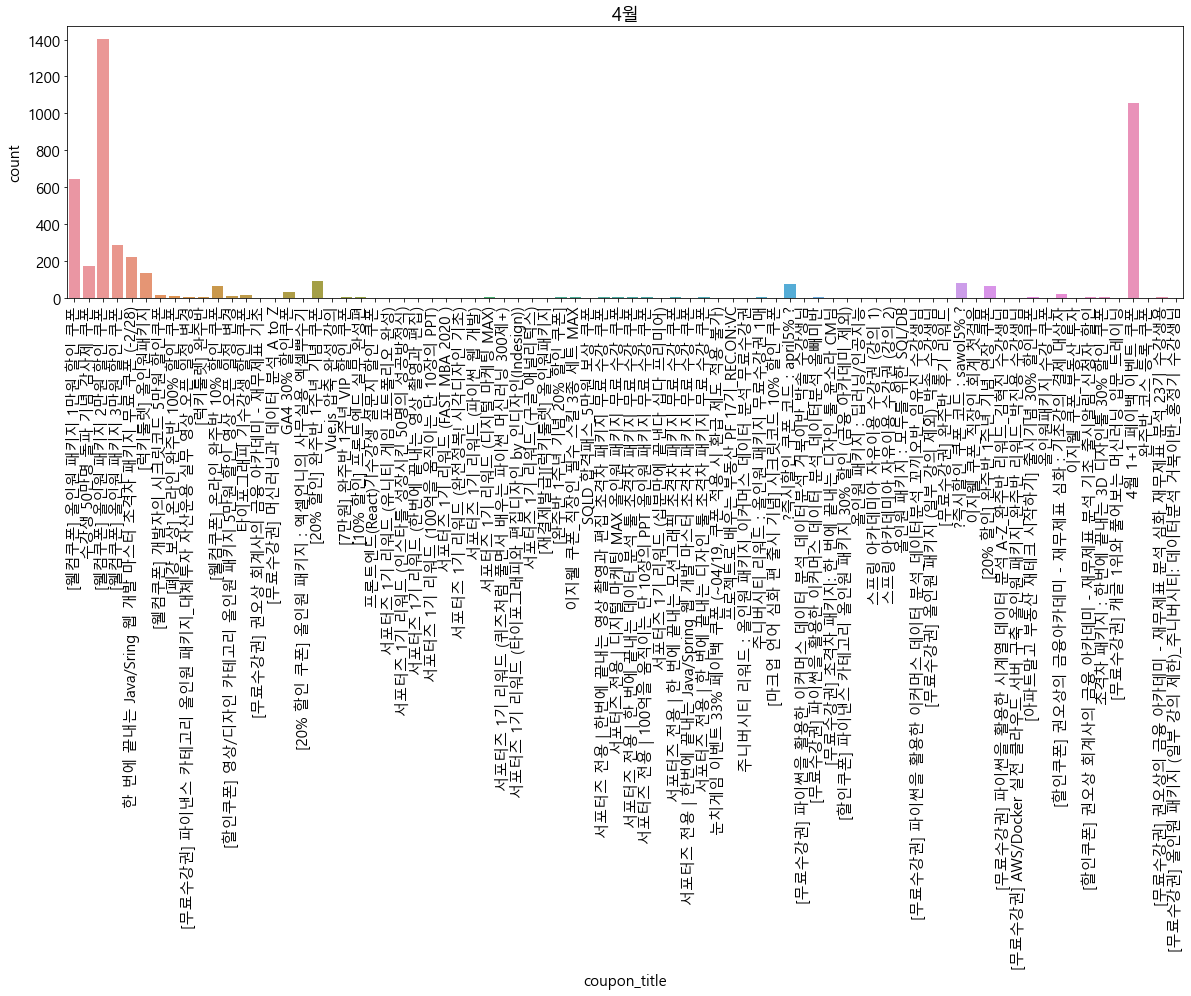

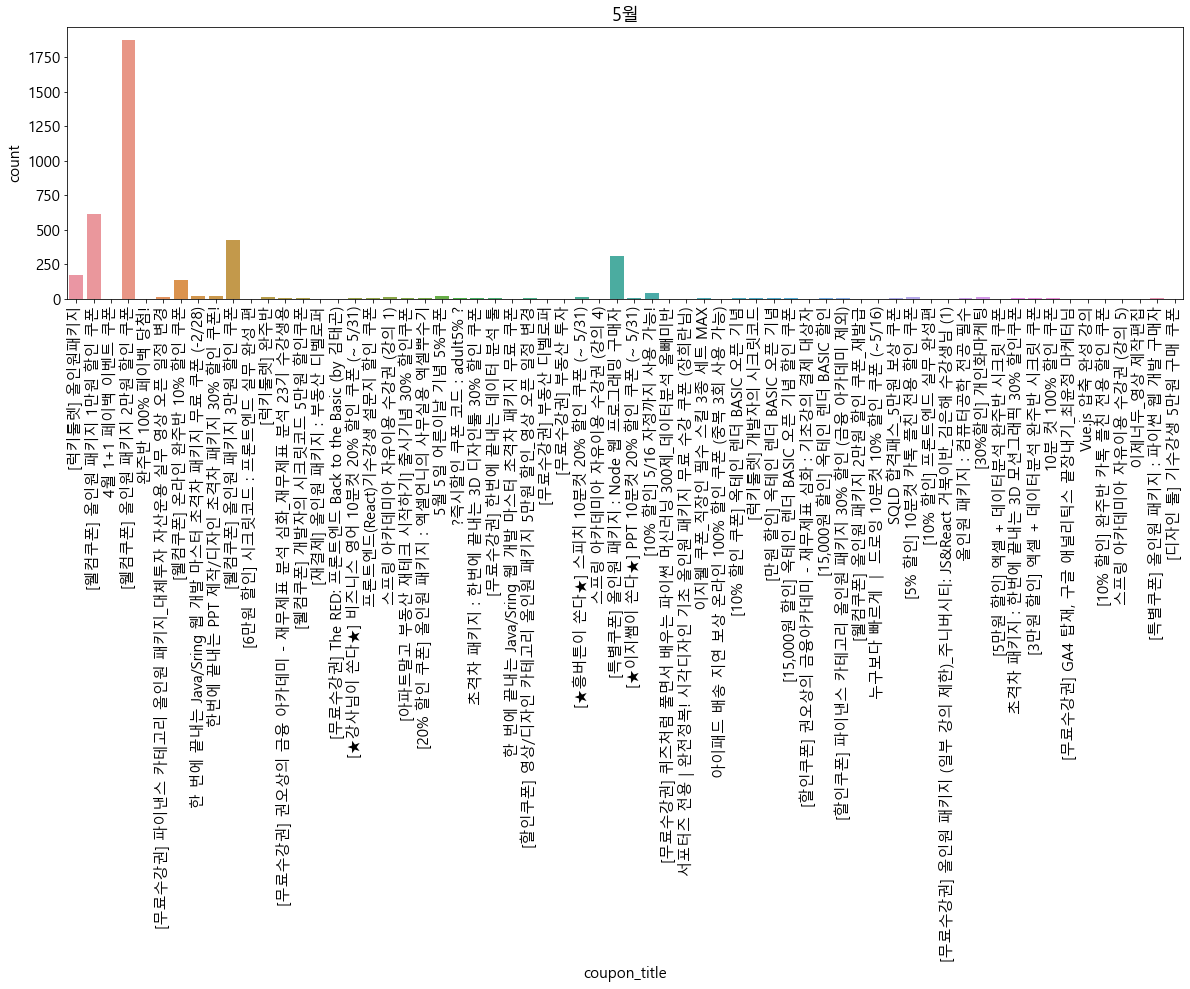

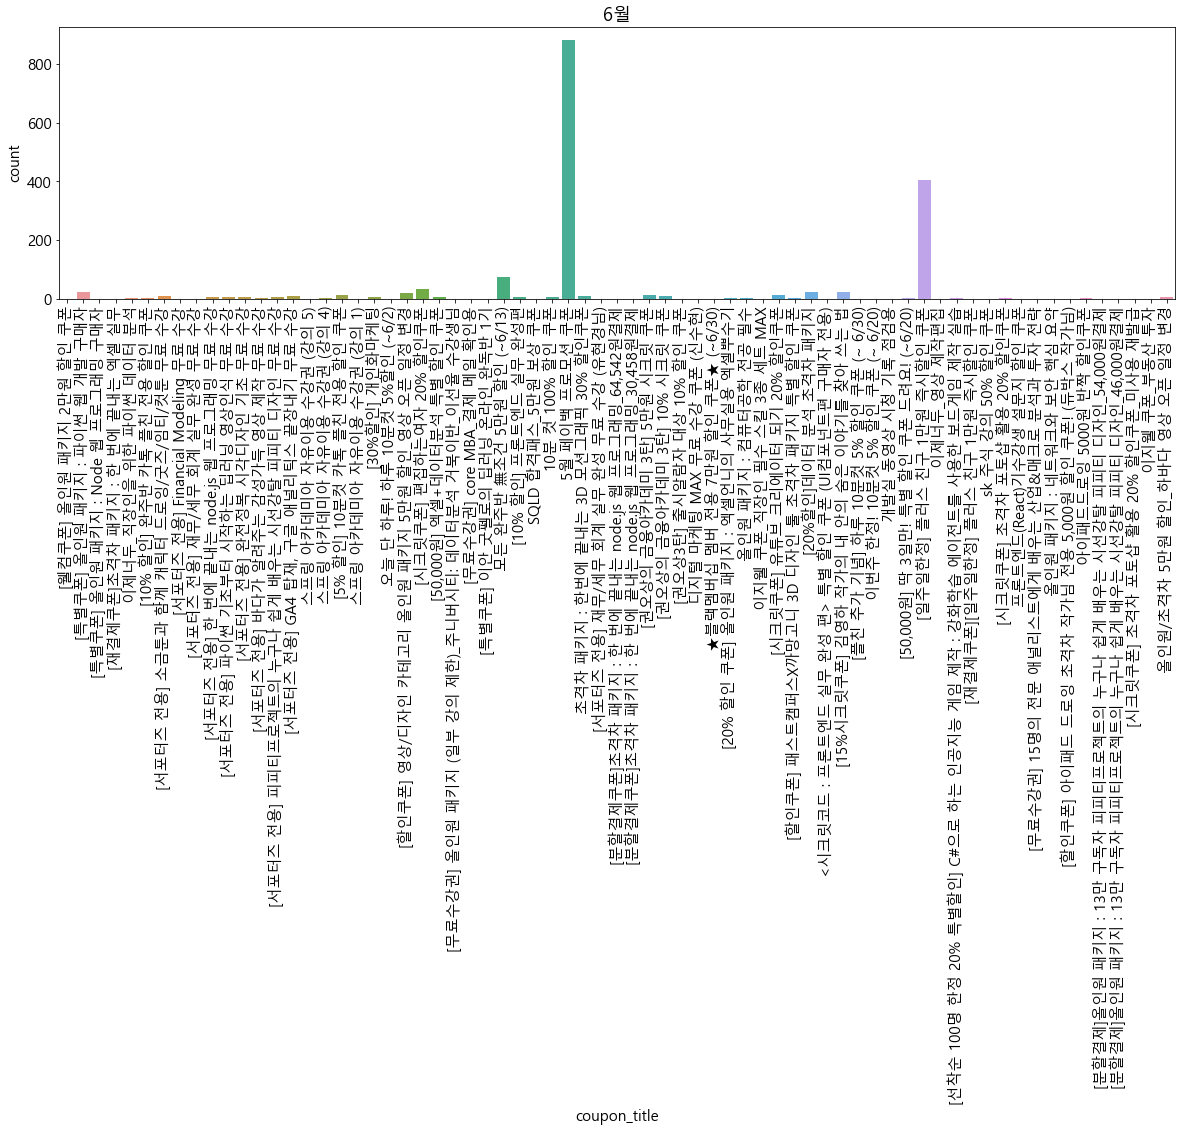

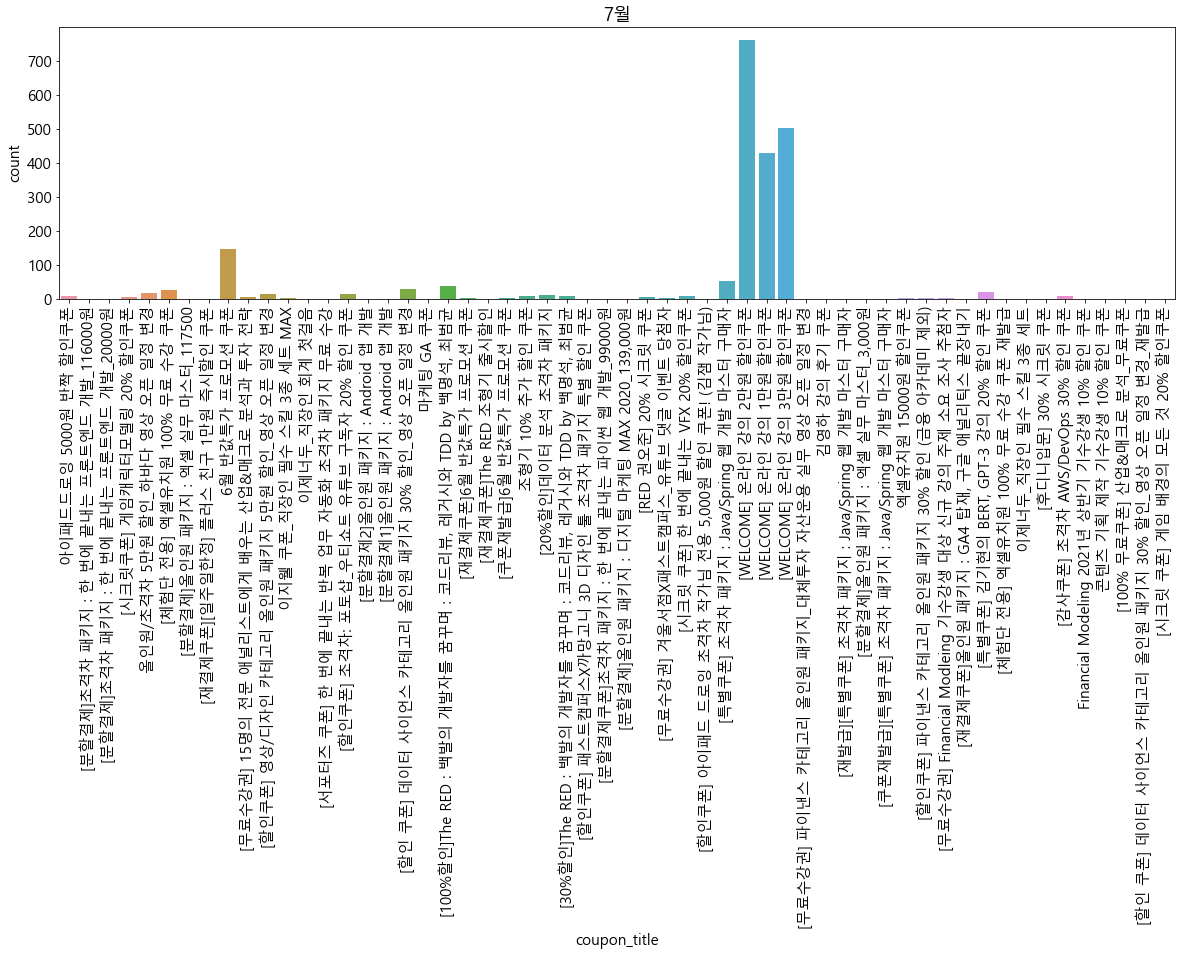

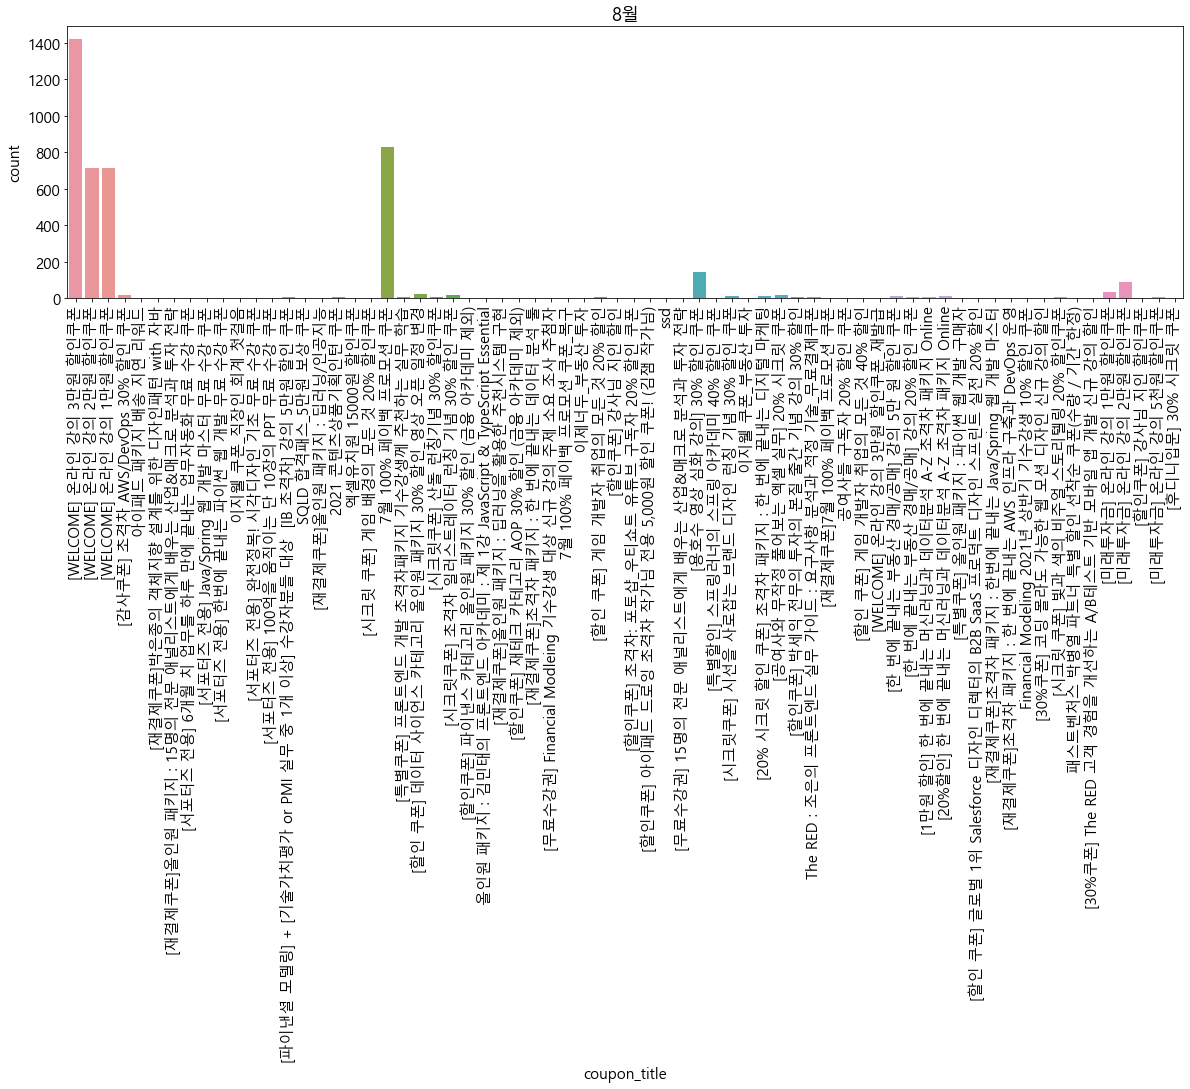

In [133]:
# 매월 쿠폰사용
for i in range(3,9):
    plt.figure(figsize=(20,5))
    plt.xticks(rotation = 90)
    plt.title(f'{i}월')
    sns.countplot(x=mon[(mon['vip']==False)&(mon['completed_at']==f'2021-0{i}')]['coupon_title'],data=mon[(mon['vip']==False)&(mon['completed_at']==f'2021-0{i}')])

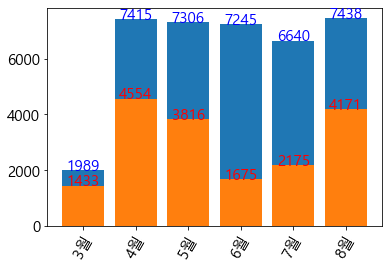

In [134]:
x_m= [] # 날짜
y_m= [] # 총 구매량
y1_m= [] # 쿠폰사용 구매량
for i in range(3,9):
        x_m.append(f'{i}월')
        y_m.append(len(mon[(mon['vip']==False)&(mon['completed_at']==f'2021-0{i}')]))
        y1_m.append(len(mon[(mon['vip']==False)&(mon['completed_at']==f'2021-0{i}')].dropna(subset=['coupon_title'])))

bar3 = plt.bar(x_m,y_m, label= "전체")
bar4 = plt.bar(x_m,y1_m, label= "쿠폰 사용")
plt.xticks(rotation=60)

for idx, rect in enumerate(bar3):
    plt.text(idx, rect.get_height()+ 0.5,y_m[idx], ha= 'center', color= 'blue')
    
for idx, rect in enumerate(bar4):
    plt.text(idx, rect.get_height()+ 0.5,y1_m[idx], ha= 'center', color= 'red')

- 위 데이터를 토대로 쿠폰의 마케팅 영향은 그리 크지 않다고 생각됨.(있으면 사용하고 없어도 구매를 하는 것으로 보임)
- 높았던 올인원에 포함되어있던 프로그래밍 카테고리가 영향이 있었을 것이라 생각되어 분석 진행

#### format 과 course_title 분석

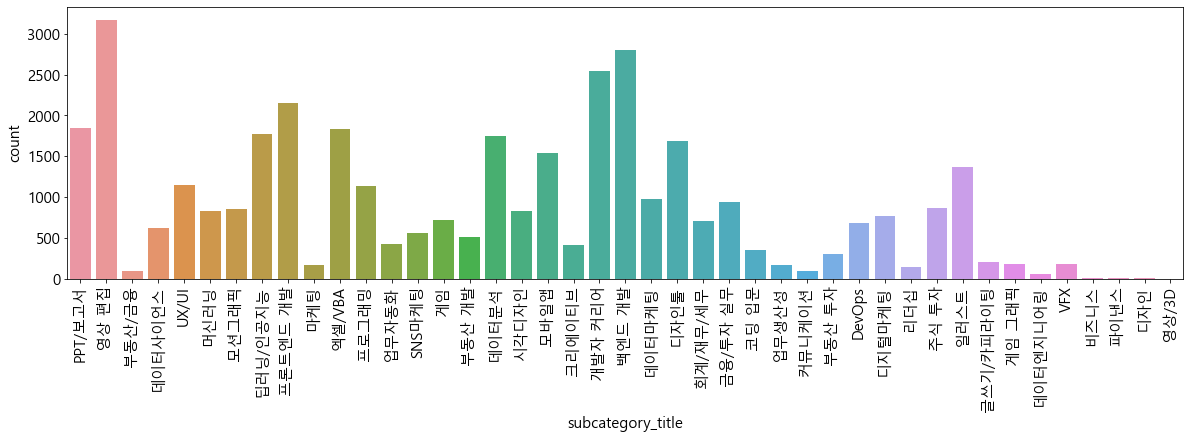

In [135]:
pt[(pt['vip']==False)&(pt['format']=='올인원')]['subcategory_title']


plt.figure(figsize=(20,5))
plt.xticks(rotation = 90)
sns.countplot(x=pt[(pt['vip']==False)&(pt['format']=='올인원')]['subcategory_title'],data=pt)
plt.show()

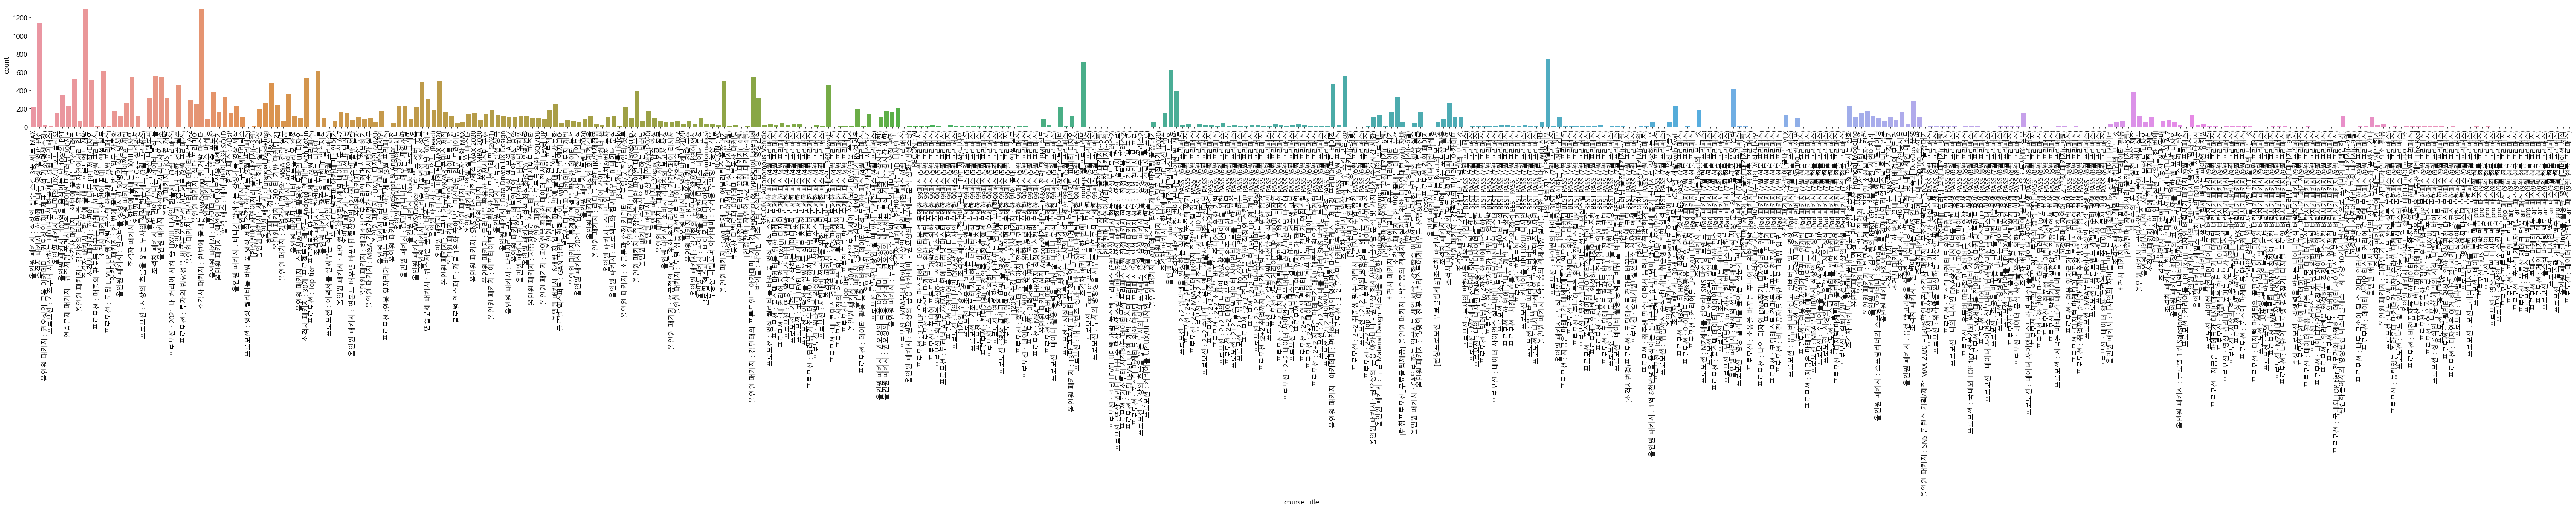

In [136]:
plt.figure(figsize=(100,5))
plt.xticks(rotation = 90)
sns.countplot(x=pt[(pt['vip']==False)&(pt['format']=='올인원')]['course_title'],data=pt)
plt.show()

In [121]:
pt[(pt['vip']==False)&(pt['format']=='올인원')]['revenue'].mean()

119666.46638016176

vip가 아닌 고객들이 구매한 Top 3 강의명을 기준으로 평균가격  -> 신규고객 또는 기존고객이 강의를 구매할 때 부담이 없을 것이라 판단

In [122]:
# 영상 촬영 편집 강의의 평균구매가격
a= int(pt[(pt['vip']==False)&(pt['format']=='올인원')&(pt['course_title']=='초격차 패키지 : 한번에 끝내는 영상 촬영과 편집')]['revenue'].mean())
# 프론트엔드 강의의 평균구매가격
b= int(pt[(pt['vip']==False)&(pt['format']=='올인원')&(pt['course_title']=="초격차 패키지 : 한 번에 끝내는 프론트엔드 개발")]['revenue'].mean())
# 웹 개발 강의의 평균구매가격
c= int(pt[(pt['vip']==False)&(pt['format']=='올인원')&(pt['course_title']=='초격차 패키지 : 한번에 끝내는 Java/Spring 웹 개발 마스터')]['revenue'].mean())

print('올인원 Top 3 강의 평균 구매가격:',(a+b+c)/3,'원')

올인원 Top 3 강의 평균 구매가격: 98304.0 원


### 결과

- 주어진 데이터 분석 결과 쿠폰 사용이 적었던 달에도 구매율이 눈에 띄게 낮지 않았음. -> 쿠폰의 영향이 적다. 라고 판단함 - > 쿠폰이 아닌 다른 조건이 관계가 있다고 볼 때,주어진 데이터에서는 강의와 가격이라고 판단됨.
- 약 6개월 기준(21.03~09)으로  올인원으로 구성된 방식이 가장 인기가 좋으며 그 중 강의 top 3(1,000명 이상 구매한 강의)의 구매가격대의 평균은 약 10만원이다. 
- 21년9월 이후로 위와 같은 인기있는 강의의 카테고리와 가격대를 형성하여 판매한다면 신규고객과 기존고객의 유치하기에 적합해 보인다.